## Comprehensive Backtesting and Optimization of VWAP + Candlestick Pattern Strategies

This notebook implements a complete trading strategy analysis framework combining VWAP (Volume Weighted Average Price) with various candlestick patterns for systematic backtesting, optimization, and performance evaluation.

## 1. Environment Setup and Data Loading

In [71]:
# Import all necessary libraries
import backtesting
import pandas as pd
import numpy as np
import talib as ta
import random

from datetime import datetime, timedelta
import time
from typing import List, Dict, Tuple, Optional

import os
from pathlib import Path

# Backtesting libraries
from backtesting import Strategy, Backtest
# Use browser output for Bokeh plots (avoids the notebook-detection warning)
backtesting.set_bokeh_output(notebook=False)

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

from IPython.display import display

# Optimization and statistics
from sklearn.model_selection import TimeSeriesSplit

# Configure warnings and display settings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(
    "ignore",
    message="Jupyter Notebook detected. Setting Bokeh output to notebook.*"
)

import traceback

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

In [72]:
# import yfinance as yf

# def download_data(tickers, start_date, end_date=None, save_path=None):
#     """
#     Download historical stock data from Yahoo Finance and save to CSV.
    
#     Parameters:
#     -----------
#     tickers : list
#         List of stock ticker symbols (e.g., ['AAPL', 'MSFT', 'GOOGL'])
#     start_date : str
#         Start date in format "YYYY-MM-DD"
#     end_date : str, optional
#         End date in format "YYYY-MM-DD". If None, uses current date
#     save_path : str, optional
#         Custom path to save CSV. If None, uses auto-generated name
    
#     Returns:
#     --------
#     pd.DataFrame
#         Downloaded stock data with MultiIndex columns (Ticker, OHLCV)
#     str
#         Path where the CSV file was saved
#     """
    
#     # Set end_date to current date if not provided
#     if end_date is None:
#         end_date = datetime.now().strftime("%Y-%m-%d")
    
#     # Download data from Yahoo Finance
#     print(f"Downloading data for {len(tickers)} tickers from {start_date} to {end_date}...")
#     data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')
    
#     # Generate filename if not provided
#     if save_path is None:
#         tickers_str = "_".join(tickers)
#         filename = f"data_{tickers_str}_{start_date}_{end_date}_raw.csv"
#     else:
#         filename = save_path
    
#     # Save to CSV
#     data.to_csv(filename)
#     print(f"Data saved to: {filename}")
    
#     # Load the CSV back with proper MultiIndex structure
#     df = pd.read_csv(filename, header=[0,1], index_col=0)
    
#     # Clean the data
#     df = df.dropna(how='all')  # Drop completely NaN rows
#     df = df.astype(float)      # Convert to float
    
#     print(f"Data shape: {df.shape}")
#     print("Download completed successfully!")
    
#     return df, filename

# # Example usage:
# if __name__ == "__main__":
#     # Define portfolio
#     tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'V', 'WMT', 'NFLX', 'RACE', 'PFE']
    
#     # Download data
#     df, saved_file = download_data(
#         tickers=tickers,
#         start_date="2020-01-01",
#         end_date=None  # Indicate specific date ("YYYY-MM-DD") or leave None for current date
#     )
    
#     # Show result
#     print(f"\nFirst 5 rows of downloaded data:")
#     print(df.head())

In [73]:
# Load and validate data
def load_market_data(file_path: str) -> pd.DataFrame:
    """
    Load market data from CSV with proper error handling
    """
    try:
        # Load the CSV with MultiIndex columns (Tickers, OHLCV)
        df = pd.read_csv(file_path, header=[0,1], index_col=0)
        
        # Drop any rows that are completely NaN
        df = df.dropna(how='all')
        
        # Convert all values to float
        df = df.astype(float)
        
        # Convert index to datetime
        df.index = pd.to_datetime(df.index)

        print(f"Data loaded successfully: {df.shape}")
        print(f"Date range: {df.index.min()} to {df.index.max()}")
        print(f"Tickers: {list(df.columns.levels[0])}")

        return df
        
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        raise
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

# Load the data
data_path = "../00_data/data_AAPL_MSFT_GOOGL_AMZN_TSLA_META_NVDA_V_WMT_NFLX_RACE_PFE_2020-01-01_2025-11-23_raw.csv"
df_raw = load_market_data(data_path)

# Display data info
print("\nData Overview:")
df_raw.tail()

Data loaded successfully: (1482, 60)
Date range: 2020-01-02 00:00:00 to 2025-11-21 00:00:00
Tickers: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NFLX', 'NVDA', 'PFE', 'RACE', 'TSLA', 'V', 'WMT']

Data Overview:


Ticker           GOOGL                                                  \
Price             Open        High         Low       Close      Volume   
Date                                                                     
2025-11-17  285.779999  293.950012  283.570007  285.019989  52670200.0   
2025-11-18  287.920013  288.799988  278.200012  284.279999  49158700.0   
2025-11-19  287.160004  303.809998  286.630005  292.809998  68198900.0   
2025-11-20  304.540009  306.420013  288.670013  289.450012  62025200.0   
2025-11-21  296.420013  303.920013  293.850006  299.660004  73945800.0   

Ticker            AMZN                                                  ...  \
Price             Open        High         Low       Close      Volume  ...   
Date                                                                    ...   
2025-11-17  233.250000  234.600006  229.190002  232.869995  59919000.0  ...   
2025-11-18  228.100006  230.199997  222.419998  222.550003  60608400.0  ...   
2025-11-19  223.740005  223.740005  218.520004  222.690002  58335600.0  ...   
2025-11-20  227.050003  227.410004  216.740005  217.139999  50309000.0  ...   
2025-11-21  216.350006  222.210007  215.179993  220.690002  68435400.0  ...   

Ticker            MSFT                                                  \
Price             Open        High         Low       Close      Volume   
Date                                                                     
2025-11-17  507.500160  511.163287  503.966764  506.541931  19092800.0   
2025-11-18  494.444589  502.040388  485.870639  492.867554  33815100.0   
2025-11-19  489.184435  494.264923  481.927997  486.209991  23245300.0   
2025-11-20  492.709991  493.570007  475.500000  478.429993  26802500.0   
2025-11-21  478.500000  478.920013  468.269989  472.119995  31699600.0   

Ticker             WMT                                                  
Price             Open        High         Low       Close      Volume  
Date                                                                    
2025-11-17  102.580002  103.320000  102.099998  102.949997  15289400.0  
2025-11-18  102.980003  103.339996  101.379997  101.389999  17604500.0  
2025-11-19  101.580002  101.709999   99.680000  100.610001  22157000.0  
2025-11-20  103.940002  107.910004  102.680000  107.110001  50375900.0  
2025-11-21  107.980003  108.150002  104.720001  105.320000  41391700.0  

[5 rows x 60 columns]

## 2. Data Preprocessing and Ticker Selection

In [74]:
"""
Need to use select_random_ticker() or select_ticker() as alternative
""";

In [75]:
def select_random_ticker(df: pd.DataFrame, seed: Optional[int] = None) -> Tuple[str, pd.DataFrame]:
    """
    Select a random ticker and return cleaned data
    """
    if seed:
        random.seed(seed)
        np.random.seed(seed)
    
    # Get available tickers
    tickers = list(df.columns.levels[0])
    selected_ticker = random.choice(tickers)
    
    print(f"Randomly selected ticker: {selected_ticker}")
    
    # Extract data for selected ticker
    ticker_data = df.xs(selected_ticker, level=0, axis=1)
    
    # Clean column names (lowercase)
    # ticker_data.columns = [col.lower() for col in ticker_data.columns]
    
    # Remove any remaining NaN values
    ticker_data = ticker_data.dropna()
    
    print(f"Clean data shape: {ticker_data.shape}")
    print(f"Date range: {ticker_data.index.min()} to {ticker_data.index.max()}")
    
    return selected_ticker, ticker_data

# Select ticker and prepare data
# RANDOM_SEED = 42  # For reproducibility
# RANDOM_SEED should have also the possibility to randomly select an integer, 
# so that different runs can analyze different tickers
RANDOM_SEED = random.randint(1, 100)
ticker_name, df_clean = select_random_ticker(df_raw, seed=RANDOM_SEED)

# Display cleaned data
print(f"\nSample data for {ticker_name}:")
display(df_clean.head())

Randomly selected ticker: GOOGL
Clean data shape: (1482, 5)
Date range: 2020-01-02 00:00:00 to 2025-11-21 00:00:00

Sample data for GOOGL:


Price,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,66.958671,67.965225,66.863328,67.965225,27278000.0
2020-01-03,66.938323,68.217003,66.904552,67.609688,23408000.0
2020-01-06,67.118577,69.437089,67.087298,69.411766,46768000.0
2020-01-07,69.543357,69.694316,69.101405,69.277687,34330000.0
2020-01-08,69.263281,70.108950,69.154534,69.770782,35314000.0


### Add date filtering

In [76]:
# # Date filtering
# start_date = "2022-01-01"
# end_date = "2023-01-01"

# df_clean = df_clean[(df_clean.index >= start_date) & (df_clean.index <= end_date)]

# # Display filtered data
# print(f"\nFiltered data for {ticker_name} from {start_date} to {end_date}:")
# display(df_clean.head())

### Select specific ticker

In [77]:
# def select_ticker(df, ticker):
#     """
#     Select data for a specific ticker from MultiIndex DataFrame.
    
#     Parameters:
#     -----------
#     df : pd.DataFrame
#         MultiIndex DataFrame with (Ticker, OHLCV) structure
#     ticker : str
#         Ticker symbol to select (e.g., 'AAPL', 'MSFT', 'GOOGL')
    
#     Returns:
#     --------
#     pd.DataFrame
#         DataFrame with only the selected ticker's data
#         Columns: ['Open', 'High', 'Low', 'Close', 'Volume']
#     """
    
#     # Check if ticker exists in the DataFrame
#     available_tickers = df.columns.get_level_values(0).unique().tolist()
    
#     if ticker not in available_tickers:
#         raise ValueError(f"Ticker '{ticker}' not found. Available tickers: {available_tickers}")
    
#     # Select the ticker from level 0 of MultiIndex
#     ticker_data = df[ticker].copy()
    
#     print(f"Selected data for {ticker}")
#     print(f"Date range: {ticker_data.index.min()} to {ticker_data.index.max()}")
#     print(f"Shape: {ticker_data.shape}")
    
#     return ticker_data

# # # Enhanced version with additional functionality
# # def select_ticker_advanced(df, ticker, columns=None, start_date=None, end_date=None):
# #     """
# #     Select data for a specific ticker with additional filtering options.
    
# #     Parameters:
# #     -----------
# #     df : pd.DataFrame
# #         MultiIndex DataFrame with (Ticker, OHLCV) structure
# #     ticker : str
# #         Ticker symbol to select
# #     columns : list, optional
# #         Specific columns to select (e.g., ['Open', 'Close'])
# #     start_date : str, optional
# #         Start date for filtering (format: 'YYYY-MM-DD')
# #     end_date : str, optional
# #         End date for filtering (format: 'YYYY-MM-DD')
    
# #     Returns:
# #     --------
# #     pd.DataFrame
# #         Filtered DataFrame for the selected ticker
# #     """
    
# #     # Get available tickers
# #     available_tickers = df.columns.get_level_values(0).unique().tolist()
    
# #     if ticker not in available_tickers:
# #         raise ValueError(f"Ticker '{ticker}' not found. Available tickers: {available_tickers}")
    
# #     # Select ticker data
# #     ticker_data = df[ticker].copy()
    
# #     # Filter by columns if specified
# #     if columns is not None:
# #         available_columns = ticker_data.columns.tolist()
# #         invalid_columns = [col for col in columns if col not in available_columns]
        
# #         if invalid_columns:
# #             raise ValueError(f"Invalid columns {invalid_columns}. Available: {available_columns}")
        
# #         ticker_data = ticker_data[columns]
    
# #     # Filter by date range if specified
# #     if start_date is not None:
# #         ticker_data = ticker_data[ticker_data.index >= start_date]
    
# #     if end_date is not None:
# #         ticker_data = ticker_data[ticker_data.index <= end_date]
    
# #     print(f"Selected data for {ticker}")
# #     if columns:
# #         print(f"Columns: {columns}")
# #     print(f"Date range: {ticker_data.index.min()} to {ticker_data.index.max()}")
# #     print(f"Shape: {ticker_data.shape}")
    
# #     return ticker_data

# # # Utility function to list available tickers
# # def list_available_tickers(df):
# #     """
# #     List all available tickers in the MultiIndex DataFrame.
    
# #     Parameters:
# #     -----------
# #     df : pd.DataFrame
# #         MultiIndex DataFrame
    
# #     Returns:
# #     --------
# #     list
# #         List of available ticker symbols
# #     """
# #     tickers = df.columns.get_level_values(0).unique().tolist()
# #     print(f"Available tickers ({len(tickers)}): {tickers}")
# #     return tickers

In [78]:
# # Basic usage - select all data for NVDA
# ticker_name = 'NVDA'
# ticker_data = select_ticker(df_raw, ticker_name)
# # Clean column names (lowercase)
# ticker_data.columns = [col.lower() for col in ticker_data.columns]
# df_clean = ticker_data.copy()
# print(ticker_data.head())

# # # Advanced usage - select specific columns
# # aapl_price = select_ticker_advanced(df_raw, 'AAPL', columns=['Open', 'Close'])

# # # Advanced usage - select data for specific date range
# # googl_recent = select_ticker_advanced(
# #     df_raw, 'GOOGL', 
# #     start_date='2024-01-01', 
# #     end_date='2024-12-31'
# # )

# # # Advanced usage - combine filters
# # meta_filtered = select_ticker_advanced(
# #     df_raw, 'META',
# #     columns=['Close', 'Volume'],
# #     start_date='2023-01-01'
# # )

# # # List all available tickers
# # available_tickers = list_available_tickers(df_raw)

## 3. Indicator Calculation Functions

In [79]:
# # Define all indicator calculation functions
def calculate_vwap(df: pd.DataFrame) -> pd.Series:
    """Calculate VWAP (Volume Weighted Average Price)"""
    try:
        typical_price = (df['High'] + df['Low'] + df['Close']) / 3
        vwap = (df['Volume'] * typical_price).cumsum() / df['Volume'].cumsum()
        return vwap
    except Exception as e:
        print(f"Error calculating VWAP: {e}")
        return pd.Series(index=df.index, dtype=float)

# def calculate_atr(df: pd.DataFrame, period: int = 14) -> pd.Series:
#     """Calculate ATR (Average True Range)"""
#     try:
#         high_low = df['high'] - df['low']
#         high_close = (df['high'] - df['close'].shift()).abs()
#         low_close = (df['low'] - df['close'].shift()).abs()
#         true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
#         atr = true_range.rolling(window=period).mean()
#         return atr
#     except Exception as e:
#         print(f"Error calculating ATR: {e}")
#         return pd.Series(index=df.index, dtype=float)

# def calculate_candlestick_pattern(df: pd.DataFrame, pattern_name: str) -> pd.Series:
#     """Calculate a specific candlestick pattern"""
#     try:
#         pattern_func = getattr(ta, pattern_name)
#         result = pattern_func(df['open'], df['high'], df['low'], df['close'])
#         return pd.Series(result, index=df.index)
#     except Exception as e:
#         print(f"Error calculating {pattern_name}: {e}")
#         return pd.Series(index=df.index, dtype=float)

# Define all candlestick patterns
CANDLESTICK_PATTERNS = [
    # Bullish reversal patterns
    'CDLHAMMER', 'CDLINVERTEDHAMMER', 'CDLMORNINGSTAR', 'CDLMORNINGDOJISTAR',
    'CDLENGULFING', 'CDLPIERCING', 'CDLHARAMI', 'CDLHARAMICROSS', 'CDLTAKURI',
    
    # Bullish continuation patterns  
    'CDL3WHITESOLDIERS', 'CDLRISEFALL3METHODS', 'CDLMATHOLD', 
    'CDLSEPARATINGLINES', 'CDLTASUKIGAP',
    
    # Bullish bottom patterns
    'CDLABANDONEDBABY', 'CDLLADDERBOTTOM', 'CDLMATCHINGLOW', 'CDLUNIQUE3RIVER',
    
    # Bullish special patterns
    'CDL3INSIDE', 'CDL3OUTSIDE', 'CDLBELTHOLD', 'CDLBREAKAWAY',
    'CDLKICKING', 'CDLKICKINGBYLENGTH', 'CDLSTICKSANDWICH'
]

print(f"Available candlestick patterns: {len(CANDLESTICK_PATTERNS)}")
for i, pattern in enumerate(CANDLESTICK_PATTERNS, 1):
    print(f"{i:2d}. {pattern}")

Available candlestick patterns: 25
 1. CDLHAMMER
 2. CDLINVERTEDHAMMER
 3. CDLMORNINGSTAR
 4. CDLMORNINGDOJISTAR
 5. CDLENGULFING
 6. CDLPIERCING
 7. CDLHARAMI
 8. CDLHARAMICROSS
 9. CDLTAKURI
10. CDL3WHITESOLDIERS
11. CDLRISEFALL3METHODS
12. CDLMATHOLD
13. CDLSEPARATINGLINES
14. CDLTASUKIGAP
15. CDLABANDONEDBABY
16. CDLLADDERBOTTOM
17. CDLMATCHINGLOW
18. CDLUNIQUE3RIVER
19. CDL3INSIDE
20. CDL3OUTSIDE
21. CDLBELTHOLD
22. CDLBREAKAWAY
23. CDLKICKING
24. CDLKICKINGBYLENGTH
25. CDLSTICKSANDWICH


## 4. Strategy Configuration and Generation

In [80]:
def generate_strategy_configs(patterns: List[str]) -> List[Dict]:
    """
    Generate strategy configurations for all VWAP + candlestick combinations
    """
    strategies = []
    
    for pattern in patterns:
        strategy_config = {
            'name': f'VWAP_{pattern}',
            'primary_indicator': 'VWAP',
            'secondary_indicator': pattern,
            'description': f'VWAP combined with {pattern} candlestick pattern',
            'atr_period': 14,
            'sl_multiplier': 1.5,
            'tp_multiplier': 3.0,
            'pattern_function': pattern
        }
        strategies.append(strategy_config)
    
    return strategies

# Generate all strategy configurations
strategy_configs = generate_strategy_configs(CANDLESTICK_PATTERNS)

print(f"Generated {len(strategy_configs)} strategy configurations:")
print("\nStrategy List:")
for i, config in enumerate(strategy_configs[:10], 1):  # Show first 10
    print(f"{i:2d}. {config['name']} - {config['description']}")

if len(strategy_configs) > 10:
    print(f"    ... and {len(strategy_configs) - 10} more strategies")

print(f"\nSample strategy configuration:")
display(pd.DataFrame([strategy_configs[0]]).T)

Generated 25 strategy configurations:

Strategy List:
 1. VWAP_CDLHAMMER - VWAP combined with CDLHAMMER candlestick pattern
 2. VWAP_CDLINVERTEDHAMMER - VWAP combined with CDLINVERTEDHAMMER candlestick pattern
 3. VWAP_CDLMORNINGSTAR - VWAP combined with CDLMORNINGSTAR candlestick pattern
 4. VWAP_CDLMORNINGDOJISTAR - VWAP combined with CDLMORNINGDOJISTAR candlestick pattern
 5. VWAP_CDLENGULFING - VWAP combined with CDLENGULFING candlestick pattern
 6. VWAP_CDLPIERCING - VWAP combined with CDLPIERCING candlestick pattern
 7. VWAP_CDLHARAMI - VWAP combined with CDLHARAMI candlestick pattern
 8. VWAP_CDLHARAMICROSS - VWAP combined with CDLHARAMICROSS candlestick pattern
 9. VWAP_CDLTAKURI - VWAP combined with CDLTAKURI candlestick pattern
10. VWAP_CDL3WHITESOLDIERS - VWAP combined with CDL3WHITESOLDIERS candlestick pattern
    ... and 15 more strategies

Sample strategy configuration:


,0
name,VWAP_CDLHAMMER
primary_indicator,VWAP
secondary_indicator,CDLHAMMER
description,VWAP combined with CDLHAMMER candlestick pattern
atr_period,14
sl_multiplier,1.5
tp_multiplier,3.0
pattern_function,CDLHAMMER


## 5. Time Series Data Splitting

In [81]:
def create_time_series_splits(df: pd.DataFrame, train_ratio: float = 0.7) -> List[dict]:
    """
    Split the input DataFrame chronologically into a single 70% train / 30% test fold.
    """
    df_sorted = df.sort_index()
    total_rows = len(df_sorted)
    if total_rows == 0:
        raise ValueError("Input DataFrame is empty.")

    split_point = int(total_rows * train_ratio)
    if split_point == 0 or split_point == total_rows:
        raise ValueError(
            "Train/test split ratio produced an empty subset. Adjust train_ratio."
        )

    print("Creating single time series split (70% train / 30% test)...")
    print(f"  Total rows: {total_rows}")
    print(f"  Train rows: {split_point} ({train_ratio * 100:.0f}%)")
    print(f"  Test rows:  {total_rows - split_point} ({(1 - train_ratio) * 100:.0f}%)")

    train_data = df_sorted.iloc[:split_point].copy()
    test_data = df_sorted.iloc[split_point:].copy()

    split_info = {
        "split_number": 1,
        "train_data": train_data,
        "test_data": test_data,
        "train_period": (train_data.index[0], train_data.index[-1]),
        "test_period": (test_data.index[0], test_data.index[-1]),
        "train_size": len(train_data),
        "test_size": len(test_data),
    }

    print(
        f"  Train period: {split_info['train_period'][0]:%Y-%m-%d} "
        f"→ {split_info['train_period'][1]:%Y-%m-%d}"
    )
    print(
        f"  Test period:  {split_info['test_period'][0]:%Y-%m-%d} "
        f"→ {split_info['test_period'][1]:%Y-%m-%d}"
    )

    return [split_info]


# Create the fixed 70/30 split
ts_splits = create_time_series_splits(df_clean, train_ratio=0.7)

# Extract train/test data (keep existing variable names)
split_info = ts_splits[0]
train_data = split_info["train_data"]
test_data = split_info["test_data"]

# Alias for downstream code as requested
# main_split = train_data

print("\nUsing the 70/30 split for the main analysis:")
print(f"Training rows: {len(train_data)}")
print(f"Testing rows:  {len(test_data)}")

Creating single time series split (70% train / 30% test)...
  Total rows: 1482
  Train rows: 1037 (70%)
  Test rows:  445 (30%)
  Train period: 2020-01-02 → 2024-02-14
  Test period:  2024-02-15 → 2025-11-21

Using the 70/30 split for the main analysis:
Training rows: 1037
Testing rows:  445


In [82]:
# # old, fixed

# """
# test_data df, include the three test splits created before
# If run test_data .head() or .tail(), it shows the last split used for testing
# """;

# def create_time_series_splits(df: pd.DataFrame, n_splits: int = 3) -> List[Tuple]:
#     """
#     Create time series cross-validation splits
#     """
#     tscv = TimeSeriesSplit(n_splits=n_splits)
#     splits = []
    
#     print(f"Creating {n_splits} time series splits...")
    
#     for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
#         train_start = df.index[train_idx[0]]
#         train_end = df.index[train_idx[-1]]
#         test_start = df.index[test_idx[0]]
#         test_end = df.index[test_idx[-1]]
        
#         train_data = df.iloc[train_idx]
#         test_data = df.iloc[test_idx]
        
#         split_info = {
#             'split_number': i + 1,
#             'train_data': train_data,
#             'test_data': test_data,
#             'train_period': (train_start, train_end),
#             'test_period': (test_start, test_end),
#             'train_size': len(train_data),
#             'test_size': len(test_data)
#         }
        
#         splits.append(split_info)
        
#         print(f"Split {i+1}:")
#         print(f"  Train: {train_start.strftime('%Y-%m-%d')} to {train_end.strftime('%Y-%m-%d')} ({len(train_data)} days)")
#         print(f"  Test:  {test_start.strftime('%Y-%m-%d')} to {test_end.strftime('%Y-%m-%d')} ({len(test_data)} days)")
    
#     return splits

# # Create time series splits
# ts_splits = create_time_series_splits(df_clean, n_splits=3)

# # Use the last split for main analysis (largest training set)
# main_split = ts_splits[-1]
# train_data = main_split['train_data']
# test_data = main_split['test_data']

# print(f"\nUsing split {main_split['split_number']} for main analysis:")
# print(f"Training data: {len(train_data)} days")
# print(f"Testing data: {len(test_data)} days")

## 6. Dynamic Strategy Class Creation

In [83]:
def create_vwap_strategy_class(pattern_name: str, atr_period: int = 14, 
                              sl_multiplier: float = 1.5, tp_multiplier: float = 3.0):
    """
    Dynamically create a VWAP + Candlestick strategy class
    """
    
    class VWAPCandlestickStrategy(Strategy):
        def init(self):
            # Store parameters as instance attributes
            self.atr_period = atr_period
            self.sl_multiplier = sl_multiplier
            self.tp_multiplier = tp_multiplier
            self.pattern_name = pattern_name
            
            # Calculate VWAP
            typical_price = (self.data.High + self.data.Low + self.data.Close) / 3
            volume_price = typical_price * self.data.Volume
            self.vwap = self.I(lambda: volume_price.cumsum() / self.data.Volume.cumsum(), name='VWAP')
            
            # Calculate ATR
            self.atr = self.I(ta.ATR, self.data.High, self.data.Low, self.data.Close, 
                             self.atr_period, name='ATR')
            
            # Calculate candlestick pattern
            pattern_func = getattr(ta, self.pattern_name)
            self.pattern = self.I(pattern_func, self.data.Open, self.data.High, 
                                 self.data.Low, self.data.Close, name=self.pattern_name)
            
            # Track entry levels
            """
            The entry_price uses the Close price (self.data.Close[-1]) 
            from the OHLC data when the buy signal is triggered.
            This occurs in the next() method 
            of the VWAPCandlestickStrategy class when the entry conditions are me
            """
            self.entry_price = None
            self.stop_loss_level = None
            self.take_profit_level = None
        
        def next(self):
            # Entry conditions: Price above VWAP AND bullish candlestick pattern
            if (not self.position and 
                self.data.Close[-1] > self.vwap[-1] and  # Price above VWAP
                self.pattern[-1] > 0):  # Bullish pattern detected
                
                # Enter long position
                self.buy()
                
                # Set stop loss and take profit levels
                self.entry_price = self.data.Close[-1]
                self.stop_loss_level = self.entry_price - (self.atr[-1] * self.sl_multiplier)
                self.take_profit_level = self.entry_price + (self.atr[-1] * self.tp_multiplier)
            
            # Exit conditions
            if self.position:
                # Stop Loss
                if self.data.Low[-1] <= self.stop_loss_level:
                    self.position.close()
                    self.entry_price = None
                # Take Profit  
                elif self.data.High[-1] >= self.take_profit_level:
                    self.position.close()
                    self.entry_price = None
    
    # Set class name dynamically and add attributes for debugging
    VWAPCandlestickStrategy.__name__ = f"VWAP{pattern_name}Strategy"
    VWAPCandlestickStrategy.atr_period = atr_period
    VWAPCandlestickStrategy.sl_multiplier = sl_multiplier
    VWAPCandlestickStrategy.tp_multiplier = tp_multiplier
    VWAPCandlestickStrategy.pattern_name = pattern_name
    
    return VWAPCandlestickStrategy

# Test strategy class creation using parameters from strategy_configs
print("Testing strategy class creation with config parameters...")
test_config = strategy_configs[0]  # Use first strategy config
"""
This code implements a strategy validation mechanism that tests the dynamic strategy class creation process 
using actual configuration parameters from the generated strategy pool.
This ensures that the strategy class creation function works correctly with the same parameter structure 
and data types that will be used during the full backtesting process
"""
TestStrategy = create_vwap_strategy_class(
    pattern_name=test_config['pattern_function'],
    atr_period=test_config['atr_period'],
    sl_multiplier=test_config['sl_multiplier'],
    tp_multiplier=test_config['tp_multiplier']
)
print(f"Created strategy class: {TestStrategy.__name__}")
print(f"Strategy pattern: {TestStrategy.pattern_name}")
print(f"Parameters: ATR={TestStrategy.atr_period}, SL={TestStrategy.sl_multiplier}, TP={TestStrategy.tp_multiplier}")

Testing strategy class creation with config parameters...
Created strategy class: VWAPCDLHAMMERStrategy
Strategy pattern: CDLHAMMER
Parameters: ATR=14, SL=1.5, TP=3.0


## 7. Batch Backtesting Execution

In [84]:
def run_single_backtest(strategy_config: Dict, data: pd.DataFrame, 
                            cash: float = 100000, commission: float = 0.002) -> Dict:
    """
    Run a single backtest for a strategy configuration
    """
    try:
        # Prepare data (backtesting library expects uppercase columns)
        df_backtest = data.copy()
        df_backtest.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        
        # Create strategy class
        StrategyClass = create_vwap_strategy_class(
            pattern_name=strategy_config['pattern_function'],
            atr_period=strategy_config['atr_period'],
            sl_multiplier=strategy_config['sl_multiplier'],
            tp_multiplier=strategy_config['tp_multiplier']
        )
        
        # Run backtest
        bt = Backtest(
            df_backtest,
            StrategyClass,
            cash=cash,
            commission=commission,
            finalize_trades=True  # close open trades at backtest end to avoid warnings
        )
        results = bt.run()
        
        # Add strategy info to results
        result_dict = results.to_dict()
        result_dict['strategy_name'] = strategy_config['name']
        result_dict['pattern'] = strategy_config['pattern_function']
        result_dict['backtest_object'] = bt
        result_dict['success'] = True
        result_dict['error'] = None
        
        return result_dict
        
    except Exception as e:
        return {
            'strategy_name': strategy_config['name'],
            'pattern': strategy_config['pattern_function'],
            'success': False,
            'error': str(e),
            'Return [%]': 0,
            '# Trades': 0
        }

def run_batch_backtests(strategy_configs: List[Dict], data: pd.DataFrame) -> pd.DataFrame:
    """
    Run backtests for multiple strategies
    """
    print(f"Running backtests for all {len(strategy_configs)} strategies...")
    
    results = []
    
    # Run backtests sequentially with progress tracking
    for i, config in enumerate(strategy_configs, 1):
        print(f"({i}/{len(strategy_configs)}) Testing {config['name']}...", end=" ")
        
        result = run_single_backtest(config, data)
        results.append(result)
        
        if result['success']:
            trades = result.get('# Trades', 0)
            returns = result.get('Return [%]', 0)
            print(f"{trades} trades, {returns:.2f}% return")
        else:
            print(f"Failed: {result['error']}")
    
    # Convert to DataFrame and filter successful backtests
    results_df = pd.DataFrame(results)
    successful_results = results_df[results_df['success'] == True].copy()
    
    print(f"\nBacktest Summary:")
    print(f"Successful: {len(successful_results)}/{len(results_df)}")
    print(f"Failed: {len(results_df) - len(successful_results)}")

    if len(successful_results) > 0:
        print(f"Best performing strategy: {successful_results.loc[successful_results['Return [%]'].idxmax(), 'strategy_name']}")
        print(f"Best return: {successful_results['Return [%]'].max():.2f}%")
    
    return successful_results

# Run backtests on training data (limit to first 10 strategies for demo)
print("Starting batch backtesting on training data...")
train_results = run_batch_backtests(strategy_configs, train_data)

# Display top performing strategies
if len(train_results) > 0:
    print(f"\nTop 5 Performing Strategies (Training Data):")
    
    # Check which columns are available in the results
    available_columns = train_results.columns.tolist()
    print(f"Available columns: {available_columns}")
    
    # Define desired columns and their alternatives
    desired_columns = {
        'strategy_name': 'strategy_name',
        'Return [%]': 'Return [%]',
        '# Trades': '# Trades', 
        'Win Rate [%]': ['Win Rate [%]', 'Win Rate', 'WinRate [%]'],
        'Sharpe Ratio': ['Sharpe Ratio', 'SharpeRatio'],
        'Sortino Ratio': ['Sortino Ratio', 'SortinoRatio'],
        'Max Drawdown [%]': ['Max Drawdown [%]', 'Max. Drawdown [%]', 'MaxDrawdown [%]', 'Max Drawdown']
    }
    
    # Find which columns actually exist
    columns_to_show = []
    for desired, alternatives in desired_columns.items():
        if isinstance(alternatives, str):
            alternatives = [alternatives]
        
        found = False
        for alt in alternatives:
            if alt in available_columns:
                columns_to_show.append(alt)
                found = True
                break
        
        if not found:
            print(f"Column '{desired}' not found in results")
    
    # Display available columns
    if len(columns_to_show) > 0:
        top_strategies = train_results.nlargest(5, 'Return [%]')[columns_to_show]
        display(top_strategies)
    else:
        print("No suitable columns found for display")
        # Show first few columns of top strategies as fallback
        basic_columns = ['strategy_name', 'Return [%]', '# Trades']
        available_basic = [col for col in basic_columns if col in available_columns]
        if available_basic:
            top_strategies = train_results.nlargest(5, 'Return [%]')[available_basic]
            display(top_strategies)
        else:
            # Last resort - show all columns for top 5
            display(train_results.nlargest(5, 'Return [%]').head())

Starting batch backtesting on training data...
Running backtests for all 25 strategies...
(1/25) Testing VWAP_CDLHAMMER... 

8 trades, 2.52% return
(2/25) Testing VWAP_CDLINVERTEDHAMMER... 13 trades, -5.23% return
(3/25) Testing VWAP_CDLMORNINGSTAR... 6 trades, -17.89% return
(4/25) Testing VWAP_CDLMORNINGDOJISTAR... 1 trades, -5.25% return
(5/25) Testing VWAP_CDLENGULFING... 25 trades, 21.00% return
(6/25) Testing VWAP_CDLPIERCING... 2 trades, -13.99% return
(7/25) Testing VWAP_CDLHARAMI... 23 trades, 12.38% return
(8/25) Testing VWAP_CDLHARAMICROSS... 7 trades, 26.00% return
(9/25) Testing VWAP_CDLTAKURI... 11 trades, -10.92% return
(10/25) Testing VWAP_CDL3WHITESOLDIERS... 2 trades, -6.42% return
(11/25) Testing VWAP_CDLRISEFALL3METHODS... 0 trades, 0.00% return
(12/25) Testing VWAP_CDLMATHOLD... 0 trades, 0.00% return
(13/25) Testing VWAP_CDLSEPARATINGLINES... 5 trades, -9.65% return
(14/25) Testing VWAP_CDLTASUKIGAP... 3 trades, -2.61% return
(15/25) Testing VWAP_CDLABANDONEDBABY... 0 trades, 0.00% return
(16/25) Testing VWAP_CDLLADDERBOTTOM... 1 trades, -2.69% return
(17/25) Testing VWAP_CDLMATCHINGLOW

,strategy_name,Return [%],# Trades,Win Rate [%],Sharpe Ratio,Sortino Ratio,Max. Drawdown [%]
7,VWAP_CDLHARAMICROSS,25.998874,7,71.428571,0.814689,1.756878,-8.860473
4,VWAP_CDLENGULFING,21.002459,25,52.000000,0.366606,0.567713,-29.375767
6,VWAP_CDLHARAMI,12.379007,23,39.130435,0.213957,0.329571,-28.648607
24,VWAP_CDLSTICKSANDWICH,12.307701,2,100.000000,0.930004,1.989847,-2.386174
16,VWAP_CDLMATCHINGLOW,9.688557,9,44.444444,0.273827,0.400194,-15.396579


In [85]:
train_results.head()

,Start,End,Duration,Exposure Time [%],Equity Final [$],Equity Peak [$],Commissions [$],Return [%],Buy & Hold Return [%],Return (Ann.) [%],...,SQN,Kelly Criterion,_strategy,_equity_curve,_trades,strategy_name,pattern,backtest_object,success,error
0,2020-01-02,2024-02-14,1504 days,8.582449,102523.302251,102523.302251,2978.779100,2.523302,96.593254,0.607413,...,0.157648,0.059247,VWAPCDLHAMMERStrategy,Equity DrawdownPct Drawdow...,Size EntryBar ExitBar EntryPrice ExitP...,VWAP_CDLHAMMER,CDLHAMMER,<backtesting.backtesting.Backtest object at 0x...,True,None
1,2020-01-02,2024-02-14,1504 days,16.779171,94769.061918,126816.066128,5574.628195,-5.230938,96.593254,-1.297131,...,-0.276908,-0.060279,VWAPCDLINVERTEDHAMMERStrategy,Equity DrawdownPct Drawdow...,Size EntryBar ExitBar EntryPrice Exit...,VWAP_CDLINVERTEDHAMMER,CDLINVERTEDHAMMER,<backtesting.backtesting.Backtest object at 0x...,True,None
2,2020-01-02,2024-02-14,1504 days,2.603664,82105.796629,100000.000000,2186.742230,-17.894203,96.593254,-4.678231,...,-4.650296,NaN,VWAPCDLMORNINGSTARStrategy,Equity DrawdownPct Drawdow...,Size EntryBar ExitBar EntryPrice ExitP...,VWAP_CDLMORNINGSTAR,CDLMORNINGSTAR,<backtesting.backtesting.Backtest object at 0x...,True,None
3,2020-01-02,2024-02-14,1504 days,0.289296,94754.208127,100000.000000,389.017497,-5.245792,96.593254,-1.300891,...,NaN,NaN,VWAPCDLMORNINGDOJISTARStrategy,Equity DrawdownPct Drawdow...,Size EntryBar ExitBar EntryPrice ExitP...,VWAP_CDLMORNINGDOJISTAR,CDLMORNINGDOJISTAR,<backtesting.backtesting.Backtest object at 0x...,True,None
4,2020-01-02,2024-02-14,1504 days,27.965284,121002.459328,138643.920968,11735.669767,21.002459,96.593254,4.741722,...,0.662901,0.131878,VWAPCDLENGULFINGStrategy,Equity DrawdownPct Drawdow...,Size EntryBar ExitBar EntryPrice Exit...,VWAP_CDLENGULFING,CDLENGULFING,<backtesting.backtesting.Backtest object at 0x...,True,None


In [86]:
train_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   Start                   25 non-null     datetime64[ns] 
 1   End                     25 non-null     datetime64[ns] 
 2   Duration                25 non-null     timedelta64[ns]
 3   Exposure Time [%]       25 non-null     float64        
 4   Equity Final [$]        25 non-null     float64        
 5   Equity Peak [$]         25 non-null     float64        
 6   Commissions [$]         19 non-null     float64        
 7   Return [%]              25 non-null     float64        
 8   Buy & Hold Return [%]   25 non-null     float64        
 9   Return (Ann.) [%]       25 non-null     float64        
 10  Volatility (Ann.) [%]   25 non-null     float64        
 11  CAGR [%]                25 non-null     float64        
 12  Sharpe Ratio            19 non-null   

In [87]:
"""
available_columns from train_results, can be that added to ooo_comparison = ooo_results() and robust_strategies
""";

## 8. Out-of-Sample Testing

In [88]:
def run_out_of_sample_testing(top_results: pd.DataFrame, test_data: pd.DataFrame, 
                             top_n: int = 5) -> pd.DataFrame:
    """
    Run out-of-sample testing on top performing strategies
    """
    # Get top N strategies
    top_strategies = top_results.nlargest(top_n, 'Return [%]')

    print(f"Running out-of-sample testing on top {top_n} strategies...")

    oos_results = []
    
    for idx, strategy_row in top_strategies.iterrows():
        strategy_name = strategy_row['strategy_name']
        pattern = strategy_row['pattern']
        
        print(f"Testing {strategy_name} on out-of-sample data...", end=" ")
        
        # Find original strategy config
        original_config = next(
            (config for config in strategy_configs if config['name'] == strategy_name), 
            None
        )
        
        if original_config:
            # Run backtest on test data
            oos_result = run_single_backtest(original_config, test_data)
            
            if oos_result['success']:
                # Add in-sample performance for comparison
                oos_result['in_sample_return'] = strategy_row['Return [%]']
                oos_result['out_of_sample_return'] = oos_result['Return [%]']
                oos_result['performance_degradation'] = (
                    strategy_row['Return [%]'] - oos_result['Return [%]']
                )
                
                oos_results.append(oos_result)
                print(f"OOS Return: {oos_result['Return [%]']:.2f}% (IS: {strategy_row['Return [%]']:.2f}%)")
            else:
                print(f"Failed: {oos_result['error']}")
        else:
            print("Strategy config not found")

    return pd.DataFrame(oos_results)

# Run out-of-sample testing
if len(train_results) > 0:
    oos_results = run_out_of_sample_testing(train_results, test_data, top_n=5)
    
    if len(oos_results) > 0:
        print(f"\nOut-of-Sample Results:")
        oos_comparison = oos_results[[
            'strategy_name', 'in_sample_return', 'out_of_sample_return', 
            'performance_degradation', '# Trades', 'Win Rate [%]'
        ]].copy()
        
        display(oos_comparison)
        
        # Identify robust strategies (minimal performance degradation)
        robust_strategies = oos_comparison[oos_comparison['performance_degradation'] < 10]
        print(f"\nRobust strategies (< 10% performance degradation): {len(robust_strategies)}")
        if len(robust_strategies) > 0:
            display(robust_strategies)

Running out-of-sample testing on top 5 strategies...
Testing VWAP_CDLHARAMICROSS on out-of-sample data... OOS Return: 6.28% (IS: 26.00%)
Testing VWAP_CDLENGULFING on out-of-sample data... OOS Return: 33.43% (IS: 21.00%)
Testing VWAP_CDLHARAMI on out-of-sample data... OOS Return: 19.93% (IS: 12.38%)
Testing VWAP_CDLSTICKSANDWICH on out-of-sample data... OOS Return: 0.00% (IS: 12.31%)
Testing VWAP_CDLMATCHINGLOW on out-of-sample data... OOS Return: 3.92% (IS: 9.69%)

Out-of-Sample Results:


,strategy_name,in_sample_return,out_of_sample_return,performance_degradation,# Trades,Win Rate [%]
0,VWAP_CDLHARAMICROSS,25.998874,6.280556,19.718318,4,50.0
1,VWAP_CDLENGULFING,21.002459,33.433199,-12.430739,8,62.5
2,VWAP_CDLHARAMI,12.379007,19.934763,-7.555757,12,50.0
3,VWAP_CDLSTICKSANDWICH,12.307701,0.000000,12.307701,0,NaN
4,VWAP_CDLMATCHINGLOW,9.688557,3.917555,5.771003,4,50.0



Robust strategies (< 10% performance degradation): 3


,strategy_name,in_sample_return,out_of_sample_return,performance_degradation,# Trades,Win Rate [%]
1,VWAP_CDLENGULFING,21.002459,33.433199,-12.430739,8,62.5
2,VWAP_CDLHARAMI,12.379007,19.934763,-7.555757,12,50.0
4,VWAP_CDLMATCHINGLOW,9.688557,3.917555,5.771003,4,50.0


In [89]:
test_data.head(10)

Price,Open,High,Low,Close,Volume
Date,,,,,
2024-02-15,142.159514,142.536916,139.497879,141.792053,37590700.0
2024-02-16,142.010547,142.209174,139.180063,139.557465,31468900.0
2024-02-20,138.703345,141.106766,138.534511,140.153336,25144700.0
2024-02-21,140.481076,141.712588,139.716346,141.573547,23223300.0
2024-02-22,143.937239,144.006767,141.821840,143.102997,27191900.0
2024-02-23,142.685901,143.688977,142.447539,142.973923,19493800.0
2024-02-26,141.166358,141.464307,136.448895,136.627670,53641800.0
2024-02-27,137.074601,138.296172,136.150964,137.928711,33099200.0
2024-02-28,136.955409,137.064656,134.482474,135.445831,37328600.0


In [90]:
test_data.tail(10)

Price,Open,High,Low,Close,Volume
Date,,,,,
2025-11-10,284.420013,290.799988,282.859985,290.100006,29557300.0
2025-11-11,287.750000,291.920013,287.320007,291.309998,19842100.0
2025-11-12,291.679993,292.010010,283.690002,286.709991,24829900.0
2025-11-13,282.339996,282.839996,277.239990,278.570007,29494000.0
2025-11-14,271.410004,278.559998,270.700012,276.410004,31647200.0
2025-11-17,285.779999,293.950012,283.570007,285.019989,52670200.0
2025-11-18,287.920013,288.799988,278.200012,284.279999,49158700.0
2025-11-19,287.160004,303.809998,286.630005,292.809998,68198900.0
2025-11-20,304.540009,306.420013,288.670013,289.450012,62025200.0


In [91]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 445 entries, 2024-02-15 to 2025-11-21
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    445 non-null    float64
 1   High    445 non-null    float64
 2   Low     445 non-null    float64
 3   Close   445 non-null    float64
 4   Volume  445 non-null    float64
dtypes: float64(5)
memory usage: 20.9 KB


In [92]:
oos_results.head(3)

,Start,End,Duration,Exposure Time [%],Equity Final [$],Equity Peak [$],Commissions [$],Return [%],Buy & Hold Return [%],Return (Ann.) [%],...,_equity_curve,_trades,strategy_name,pattern,backtest_object,success,error,in_sample_return,out_of_sample_return,performance_degradation
0,2024-02-15,2025-11-21,645 days,8.988764,106280.556371,107550.777822,1617.634242,6.280556,124.532508,3.509590,...,Equity DrawdownPct Drawdow...,Size EntryBar ExitBar EntryPrice ExitP...,VWAP_CDLHARAMICROSS,CDLHARAMICROSS,<backtesting.backtesting.Backtest object at 0x...,True,None,25.998874,6.280556,19.718318
1,2024-02-15,2025-11-21,645 days,20.000000,133433.198743,135038.888457,3917.291400,33.433199,124.532508,17.743234,...,Equity DrawdownPct Drawdow...,Size EntryBar ExitBar EntryPrice ExitP...,VWAP_CDLENGULFING,CDLENGULFING,<backtesting.backtesting.Backtest object at 0x...,True,None,21.002459,33.433199,-12.430739
2,2024-02-15,2025-11-21,645 days,34.382022,119934.763441,119934.763441,5180.239916,19.934763,124.532508,10.842415,...,Equity DrawdownPct Drawdow...,Size EntryBar ExitBar EntryPrice Exit...,VWAP_CDLHARAMI,CDLHARAMI,<backtesting.backtesting.Backtest object at 0x...,True,None,12.379007,19.934763,-7.555757


In [93]:
oos_comparison.head(3)

,strategy_name,in_sample_return,out_of_sample_return,performance_degradation,# Trades,Win Rate [%]
0,VWAP_CDLHARAMICROSS,25.998874,6.280556,19.718318,4,50.0
1,VWAP_CDLENGULFING,21.002459,33.433199,-12.430739,8,62.5
2,VWAP_CDLHARAMI,12.379007,19.934763,-7.555757,12,50.0


In [94]:
def save_results_to_txt(df: pd.DataFrame, file_name: str, data_path: str = "../02_VWAP/00_bt_results"):
    """
    Save DataFrame results to a text file in the specified directory
    """
    try:
        # Create the directory if it doesn't exist
        Path(data_path).mkdir(parents=True, exist_ok=True)
        
        # Create full file path
        full_file_path = os.path.join(data_path, file_name)
        
        # Save the DataFrame to text file
        with open(full_file_path, 'w') as f:
            f.write(f"Results saved on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write("=" * 80 + "\n\n")
            f.write(df.to_string(index=False))
            f.write(f"\n\n" + "=" * 80 + "\n")
            f.write(f"Total records: {len(df)}\n")
        
        print(f"Results saved to: {full_file_path}")
        
    except Exception as e:
        print(f"Error saving results to {full_file_path}: {e}")
        
        # Try to save in current directory as fallback
        try:
            fallback_path = file_name
            with open(fallback_path, 'w') as f:
                f.write(f"Results saved on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                f.write("=" * 80 + "\n\n")
                f.write(df.to_string(index=False))
                f.write(f"\n\n" + "=" * 80 + "\n")
                f.write(f"Total records: {len(df)}\n")
            print(f"Fallback: Results saved to current directory: {fallback_path}")
        except Exception as e2:
            print(f"Failed to save even in current directory: {e2}")

def select_available_columns(df: pd.DataFrame, desired_columns: list) -> list:
    """
    Select columns that actually exist in the DataFrame from a list of desired columns
    """
    if df.empty:
        return []
    
    # # Define column mapping with alternatives
    # column_alternatives = {
    #     'Max Drawdown [%]': ['Max Drawdown [%]', 'Max. Drawdown [%]', 'MaxDrawdown [%]', 'Max Drawdown'],
    #     'Win Rate [%]': ['Win Rate [%]', 'Win Rate', 'WinRate [%]'],
    #     'Sharpe Ratio': ['Sharpe Ratio', 'SharpeRatio'],
    #     'Return [%]': ['Return [%]'],
    #     '# Trades': ['# Trades'],
    #     'strategy_name': ['strategy_name'],
    #     'Volatility (ann.) [%]': ['Volatility (ann.) [%]', 'Volatility [%]', 'Volatility']
    # }
    # Define column mapping with alternatives
    # This dict, can be better structured.. to check more alternatives
    column_alternatives = {
        'Max Drawdown [%]': ['Max. Drawdown [%]'],
        'Win Rate [%]': ['Win Rate [%]'],
        'Sharpe Ratio': ['Sharpe Ratio'],
        'Return [%]': ['Return [%]'],
        '# Trades': ['# Trades'],
        'strategy_name': ['strategy_name'],
        'Volatility (ann.) [%]': ['Volatility (ann.) [%]']
    }
    
    available_columns = df.columns.tolist()
    selected_columns = []
    
    for desired_col in desired_columns:
        # If the exact column exists, use it
        if desired_col in available_columns:
            selected_columns.append(desired_col)
        # Otherwise, check alternatives
        elif desired_col in column_alternatives:
            alternatives = column_alternatives[desired_col]
            for alt in alternatives:
                if alt in available_columns:
                    selected_columns.append(alt)
                    break
    
    return selected_columns

# Define the results directory path
results_dir = "../02_VWAP/00_bt_results"

# Save results to text files with proper column handling
if 'oos_results' in locals() and len(oos_results) > 0:
    print("Processing out-of-sample results for saving...")
    
    # Save OOS comparison if available
    if 'oos_comparison' in locals() and len(oos_comparison) > 0:
        save_results_to_txt(
            oos_comparison, 
            f"{ticker_name}_oos_comparison.txt",
            results_dir
        )
    
    # Save robust strategies if available
    if 'robust_strategies' in locals() and len(robust_strategies) > 0:
        save_results_to_txt(
            robust_strategies, 
            f"{ticker_name}_robust_strategies.txt",
            results_dir
        )
    else:
        print("No robust strategies found to save")
    
    # Save full OOS results with available columns only
    print("Available columns in oos_results:", oos_results.columns.tolist())
    
    desired_oos_columns = ['strategy_name', 'Return [%]', '# Trades', 'Win Rate [%]', 
                          'Sharpe Ratio', 'Max Drawdown [%]']
    
    available_oos_columns = select_available_columns(oos_results, desired_oos_columns)
    
    if available_oos_columns:
        print(f"Saving OOS results with columns: {available_oos_columns}")
        save_results_to_txt(
            oos_results[available_oos_columns].copy(),
            f"{ticker_name}_full_oos_results.txt",
            results_dir
        )
    else:
        print("No matching columns found for OOS results, saving all available columns")
        save_results_to_txt(
            oos_results,
            f"{ticker_name}_full_oos_results.txt",
            results_dir
        )
        
else:
    print("No out-of-sample results available to save")

# Save training results with available columns only
if 'train_results' in locals() and len(train_results) > 0:
    print("Processing training results for saving...")
    print("Available columns in train_results:", train_results.columns.tolist())
    
    # Define desired columns for training results
    desired_train_columns = ['strategy_name', 'Return [%]', '# Trades', 'Win Rate [%]', 
                            'Sharpe Ratio', 'Max Drawdown [%]']
    
    available_train_columns = select_available_columns(train_results, desired_train_columns)
    
    if available_train_columns:
        print(f"Saving training results with columns: {available_train_columns}")
        training_summary = train_results[available_train_columns].copy()
    else:
        print("No matching columns found for training results, using basic columns")
        # Fallback to basic columns that should always exist
        basic_columns = ['strategy_name', 'Return [%]', '# Trades']
        basic_available = [col for col in basic_columns if col in train_results.columns]
        if basic_available:
            training_summary = train_results[basic_available].copy()
        else:
            # Last resort - save all columns
            training_summary = train_results.copy()
    
    save_results_to_txt(
        training_summary,
        f"{ticker_name}_training_results.txt", 
        results_dir
    )
else:
    print("No training results available to save")

# print(f"\nResults directory: {os.path.abspath(results_dir)}")

# Display summary of what was saved
saved_files = []
for file_type in ['oos_comparison', 'robust_strategies', 'full_oos_results', 'training_results']:
    file_path = os.path.join(results_dir, f"{ticker_name}_{file_type}.txt")
    if os.path.exists(file_path):
        saved_files.append(f"{ticker_name}_{file_type}.txt")

if saved_files:
    print(f"\nSuccessfully saved {len(saved_files)} files:")
    for file_name in saved_files:
        print(f"  ✓ {file_name}")
else:
    print("\nNo files were saved successfully")

Processing out-of-sample results for saving...
Results saved to: ../02_VWAP/00_bt_results\GOOGL_oos_comparison.txt
Results saved to: ../02_VWAP/00_bt_results\GOOGL_robust_strategies.txt
Available columns in oos_results: ['Start', 'End', 'Duration', 'Exposure Time [%]', 'Equity Final [$]', 'Equity Peak [$]', 'Commissions [$]', 'Return [%]', 'Buy & Hold Return [%]', 'Return (Ann.) [%]', 'Volatility (Ann.) [%]', 'CAGR [%]', 'Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio', 'Alpha [%]', 'Beta', 'Max. Drawdown [%]', 'Avg. Drawdown [%]', 'Max. Drawdown Duration', 'Avg. Drawdown Duration', '# Trades', 'Win Rate [%]', 'Best Trade [%]', 'Worst Trade [%]', 'Avg. Trade [%]', 'Max. Trade Duration', 'Avg. Trade Duration', 'Profit Factor', 'Expectancy [%]', 'SQN', 'Kelly Criterion', '_strategy', '_equity_curve', '_trades', 'strategy_name', 'pattern', 'backtest_object', 'success', 'error', 'in_sample_return', 'out_of_sample_return', 'performance_degradation']
Saving OOS results with columns: ['strateg

## 9. Parameter Optimization

In [95]:
# review below cell, optimization function is not optimizing properly
"""
Seems to optimize the strategy parameters of unprofitable strategies, 
need to add a filter to only optimize profitable ones
""";

In [96]:
# working, commented out for now to remove random_state

# def optimize_strategy_parameters(strategy_config: Dict, data: pd.DataFrame, 
#                                optimize_params: Dict) -> Dict:
#     """
#     Optimize strategy parameters using grid search
#     """
#     print(f"Optimizing parameters for {strategy_config['name']}...")
    
#     try:
#         # Prepare data
#         df_backtest = data.copy()
#         df_backtest.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        
#         # Create optimizable strategy class that properly inherits parameters
#         def create_optimizable_vwap_strategy(pattern_name: str):
#             """
#             Create an optimizable VWAP strategy class with parameter optimization support
#             """
#             class OptimizableVWAPStrategy(Strategy):
#                 # Define optimizable parameters as class variables
#                 atr_period = 14        # Will be overridden during optimization
#                 sl_multiplier = 1.5    # Will be overridden during optimization
#                 tp_multiplier = 3.0    # Will be overridden during optimization
                
#                 def init(self):
#                     # Store parameters as instance attributes
#                     self.pattern_name = pattern_name
                    
#                     # Calculate VWAP
#                     typical_price = (self.data.High + self.data.Low + self.data.Close) / 3
#                     volume_price = typical_price * self.data.Volume
#                     self.vwap = self.I(lambda: volume_price.cumsum() / self.data.Volume.cumsum(), name='VWAP')
                    
#                     # Calculate ATR using the optimizable parameter
#                     self.atr = self.I(ta.ATR, self.data.High, self.data.Low, self.data.Close, 
#                                      self.atr_period, name='ATR')
                    
#                     # Calculate candlestick pattern
#                     pattern_func = getattr(ta, self.pattern_name)
#                     self.pattern = self.I(pattern_func, self.data.Open, self.data.High, 
#                                          self.data.Low, self.data.Close, name=self.pattern_name)
                    
#                     # Track entry levels
#                     self.entry_price = None
#                     self.stop_loss_level = None
#                     self.take_profit_level = None
                
#                 def next(self):
#                     # Entry conditions: Price above VWAP AND bullish candlestick pattern
#                     if (not self.position and 
#                         self.data.Close[-1] > self.vwap[-1] and  # Price above VWAP
#                         self.pattern[-1] > 0):  # Bullish pattern detected
                        
#                         # Enter long position
#                         self.buy()
                        
#                         # Set stop loss and take profit levels using optimizable parameters
#                         self.entry_price = self.data.Close[-1]
#                         self.stop_loss_level = self.entry_price - (self.atr[-1] * self.sl_multiplier)
#                         self.take_profit_level = self.entry_price + (self.atr[-1] * self.tp_multiplier)
                    
#                     # Exit conditions
#                     if self.position:
#                         # Stop Loss
#                         if self.data.Low[-1] <= self.stop_loss_level:
#                             self.position.close()
#                             self.entry_price = None
#                         # Take Profit  
#                         elif self.data.High[-1] >= self.take_profit_level:
#                             self.position.close()
#                             self.entry_price = None
            
#             return OptimizableVWAPStrategy
        
#         # Create the optimizable strategy class
#         OptimizableStrategy = create_optimizable_vwap_strategy(strategy_config['pattern_function'])
        
#         # Run optimization with proper parameter ranges
#         bt = Backtest(df_backtest, OptimizableStrategy, cash=100000, commission=0.002)
        
#         print(f"  Parameter ranges:")
#         print(f"    ATR Period: {optimize_params['atr_period']}")
#         print(f"    SL Multiplier: {optimize_params['sl_multiplier']}")
#         print(f"    TP Multiplier: {optimize_params['tp_multiplier']}")
        
#         optimization_result = bt.optimize(
#             atr_period=optimize_params['atr_period'],
#             sl_multiplier=optimize_params['sl_multiplier'], 
#             tp_multiplier=optimize_params['tp_multiplier'],
#             maximize='Sharpe Ratio',
#             max_tries=100,  # Increased max tries
#             random_state=42  # For reproducibility
#         )
        
#         # Extract optimized parameters
#         optimized_params = {
#             'atr_period': optimization_result._strategy.atr_period,
#             'sl_multiplier': optimization_result._strategy.sl_multiplier,
#             'tp_multiplier': optimization_result._strategy.tp_multiplier
#         }
        
#         print(f"  Optimized parameters: {optimized_params}")
        
#         return {
#             'strategy_name': strategy_config['name'],
#             'optimization_success': True,
#             'original_params': {
#                 'atr_period': strategy_config['atr_period'],
#                 'sl_multiplier': strategy_config['sl_multiplier'],
#                 'tp_multiplier': strategy_config['tp_multiplier']
#             },
#             'optimized_params': optimized_params,
#             'optimized_results': optimization_result.to_dict(),
#             'backtest_object': bt,
#             'optimization_stats': optimization_result._strategy
#         }
        
#     except Exception as e:
#         print(f"  Optimization failed: {str(e)}")
        
#         print(f"  Error details: {traceback.format_exc()}")
#         return {
#             'strategy_name': strategy_config['name'],
#             'optimization_success': False,
#             'error': str(e)
#         }

# # Define parameter ranges for optimization with more granular steps
# optimization_params = {
#     'atr_period': [10, 12, 14, 16, 18, 20],  # Reduced range for faster optimization
#     'sl_multiplier': [1.0, 1.2, 1.5, 1.8, 2.0],  # More focused range
#     'tp_multiplier': [2.0, 2.5, 3.0, 3.5, 4.0]  # More focused range
# }

# print(f"Total parameter combinations: {len(optimization_params['atr_period']) * len(optimization_params['sl_multiplier']) * len(optimization_params['tp_multiplier'])}")

# # Optimize top 3 strategies
# if len(train_results) >= 3:
#     top_3_strategies = train_results.nlargest(3, 'Return [%]')

#     print(f"Optimizing parameters for top 3 strategies...")
#     optimized_results = []
    
#     for idx, strategy_row in top_3_strategies.iterrows():
#         strategy_name = strategy_row['strategy_name']
        
#         # Find original config
#         original_config = next(
#             (config for config in strategy_configs if config['name'] == strategy_name),
#             None
#         )
        
#         if original_config:
#             print(f"\n{'='*60}")
#             print(f"Starting optimization for: {strategy_name}")
#             print(f"Original parameters: ATR={original_config['atr_period']}, "
#                   f"SL={original_config['sl_multiplier']}, TP={original_config['tp_multiplier']}")
            
#             opt_result = optimize_strategy_parameters(
#                 original_config, train_data, optimization_params
#             )
#             optimized_results.append(opt_result)
    
#     # Display comprehensive optimization results
#     successful_optimizations = [r for r in optimized_results if r.get('optimization_success', False)]
    
#     if successful_optimizations:
#         print(f"\n{'='*80}")
#         print("OPTIMIZATION RESULTS SUMMARY")
#         print(f"{'='*80}")
        
#         for result in successful_optimizations:
#             strategy_name = result['strategy_name']
#             original_params = result['original_params']
#             optimized_params = result['optimized_params']
            
#             print(f"\n{strategy_name}:")
#             print(f"{'Original Parameters:':<25} ATR={original_params['atr_period']}, "
#                   f"SL={original_params['sl_multiplier']}, TP={original_params['tp_multiplier']}")
#             print(f"{'Optimized Parameters:':<25} ATR={optimized_params['atr_period']}, "
#                   f"SL={optimized_params['sl_multiplier']}, TP={optimized_params['tp_multiplier']}")
            
#             # Check if parameters actually changed
#             params_changed = (
#                 original_params['atr_period'] != optimized_params['atr_period'] or
#                 original_params['sl_multiplier'] != optimized_params['sl_multiplier'] or
#                 original_params['tp_multiplier'] != optimized_params['tp_multiplier']
#             )
            
#             if params_changed:
#                 print(f"{'Status:':<25} Parameters optimized")
#             else:
#                 print(f"{'Status:':<25} No improvement found (original parameters optimal)")
            
#             opt_return = result['optimized_results'].get('Return [%]', 0)
#             opt_sharpe = result['optimized_results'].get('Sharpe Ratio', 0)
#             opt_trades = result['optimized_results'].get('# Trades', 0)
            
#             print(f"{'Optimized Performance:':<25} {opt_return:.2f}% return, "
#                   f"{opt_sharpe:.3f} Sharpe, {opt_trades} trades")
#     else:
#         print("No successful optimizations completed")
        
#         # Show failed optimizations
#         failed_optimizations = [r for r in optimized_results if not r.get('optimization_success', False)]
#         if failed_optimizations:
#             print(f"\nFailed optimizations:")
#             for result in failed_optimizations:
#                 print(f"  - {result['strategy_name']}: {result.get('error', 'Unknown error')}")
                
# else:
#     print("Not enough successful strategies for optimization")

In [97]:
from tabnanny import verbose

In [98]:
def optimize_strategy_parameters(strategy_config: Dict, data: pd.DataFrame, 
                               optimize_params: Dict) -> Dict:
    """
    Optimize strategy parameters using grid search
    """
    print(f"Optimizing parameters for {strategy_config['name']}...")
    
    try:
        # Prepare data
        df_backtest = data.copy()
        df_backtest.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        
        # Create optimizable strategy class that properly inherits parameters
        def create_optimizable_vwap_strategy(pattern_name: str):
            """
            Create an optimizable VWAP strategy class with parameter optimization support
            """
            class OptimizableVWAPStrategy(Strategy):
                # Define optimizable parameters as class variables
                atr_period = 14        # Will be overridden during optimization
                sl_multiplier = 1.5    # Will be overridden during optimization
                tp_multiplier = 3.0    # Will be overridden during optimization
                
                def init(self):
                    # Store parameters as instance attributes
                    self.pattern_name = pattern_name
                    
                    # Calculate VWAP
                    typical_price = (self.data.High + self.data.Low + self.data.Close) / 3
                    volume_price = typical_price * self.data.Volume
                    self.vwap = self.I(lambda: volume_price.cumsum() / self.data.Volume.cumsum(), name='VWAP')
                    
                    # Calculate ATR using the optimizable parameter
                    self.atr = self.I(ta.ATR, self.data.High, self.data.Low, self.data.Close, 
                                     self.atr_period, name='ATR')
                    
                    # Calculate candlestick pattern
                    pattern_func = getattr(ta, self.pattern_name)
                    self.pattern = self.I(pattern_func, self.data.Open, self.data.High, 
                                         self.data.Low, self.data.Close, name=self.pattern_name)
                    
                    # Track entry levels
                    self.entry_price = None
                    self.stop_loss_level = None
                    self.take_profit_level = None
                
                def next(self):
                    # Entry conditions: Price above VWAP AND bullish candlestick pattern
                    if (not self.position and 
                        self.data.Close[-1] > self.vwap[-1] and  # Price above VWAP
                        self.pattern[-1] > 0):  # Bullish pattern detected
                        
                        # Enter long position
                        self.buy()
                        
                        # Set stop loss and take profit levels using optimizable parameters
                        self.entry_price = self.data.Close[-1]
                        self.stop_loss_level = self.entry_price - (self.atr[-1] * self.sl_multiplier)
                        self.take_profit_level = self.entry_price + (self.atr[-1] * self.tp_multiplier)
                    
                    # Exit conditions
                    if self.position:
                        # Stop Loss
                        if self.data.Low[-1] <= self.stop_loss_level:
                            self.position.close()
                            self.entry_price = None
                        # Take Profit  
                        elif self.data.High[-1] >= self.take_profit_level:
                            self.position.close()
                            self.entry_price = None
            
            return OptimizableVWAPStrategy
        
        # Create the optimizable strategy class
        OptimizableStrategy = create_optimizable_vwap_strategy(strategy_config['pattern_function'])
        
        # Run optimization with proper parameter ranges
        bt = Backtest(df_backtest, OptimizableStrategy, cash=100000, commission=0.002)
        
        print(f"  Parameter ranges:")
        print(f"    ATR Period: {optimize_params['atr_period']}")
        print(f"    SL Multiplier: {optimize_params['sl_multiplier']}")
        print(f"    TP Multiplier: {optimize_params['tp_multiplier']}")

        # Generate dynamic random state based on current time
        dynamic_seed = int(time.time() * 1000) % 100000
        if verbose:
            print(f"Using dynamic seed: {dynamic_seed}")
        
        optimization_result = bt.optimize(
            atr_period=optimize_params['atr_period'],
            sl_multiplier=optimize_params['sl_multiplier'], 
            tp_multiplier=optimize_params['tp_multiplier'],
            maximize='Sharpe Ratio',
            max_tries=100,  # Increased max tries
            random_state=dynamic_seed  # For reproducibility
        )
        
        # Extract optimized parameters
        optimized_params = {
            'atr_period': optimization_result._strategy.atr_period,
            'sl_multiplier': optimization_result._strategy.sl_multiplier,
            'tp_multiplier': optimization_result._strategy.tp_multiplier
        }
        
        print(f"  Optimized parameters: {optimized_params}")
        
        return {
            'strategy_name': strategy_config['name'],
            'optimization_success': True,
            'original_params': {
                'atr_period': strategy_config['atr_period'],
                'sl_multiplier': strategy_config['sl_multiplier'],
                'tp_multiplier': strategy_config['tp_multiplier']
            },
            'optimized_params': optimized_params,
            'optimized_results': optimization_result.to_dict(),
            'backtest_object': bt,
            'optimization_stats': optimization_result._strategy
        }
        
    except Exception as e:
        print(f"  Optimization failed: {str(e)}")
        
        print(f"  Error details: {traceback.format_exc()}")
        return {
            'strategy_name': strategy_config['name'],
            'optimization_success': False,
            'error': str(e)
        }

# Define parameter ranges for optimization with more granular steps
optimization_params = {
    'atr_period': [10, 12, 14, 16, 18, 20],  # Reduced range for faster optimization
    'sl_multiplier': [1.0, 1.2, 1.5, 1.8, 2.0],  # More focused range
    'tp_multiplier': [2.0, 2.5, 3.0, 3.5, 4.0]  # More focused range
}

print(f"Total parameter combinations: {len(optimization_params['atr_period']) * len(optimization_params['sl_multiplier']) * len(optimization_params['tp_multiplier'])}")

# Optimize top 3 strategies
if len(train_results) >= 3:
    top_3_strategies = train_results.nlargest(3, 'Return [%]')

    print(f"Optimizing parameters for top 3 strategies...")
    optimized_results = []
    
    for idx, strategy_row in top_3_strategies.iterrows():
        strategy_name = strategy_row['strategy_name']
        
        # Find original config
        original_config = next(
            (config for config in strategy_configs if config['name'] == strategy_name),
            None
        )
        
        if original_config:
            print(f"\n{'='*60}")
            print(f"Starting optimization for: {strategy_name}")
            print(f"Original parameters: ATR={original_config['atr_period']}, "
                  f"SL={original_config['sl_multiplier']}, TP={original_config['tp_multiplier']}")
            
            opt_result = optimize_strategy_parameters(
                original_config, train_data, optimization_params
            )
            optimized_results.append(opt_result)
    
    # Display comprehensive optimization results
    successful_optimizations = [r for r in optimized_results if r.get('optimization_success', False)]
    
    if successful_optimizations:
        print(f"\n{'='*80}")
        print("OPTIMIZATION RESULTS SUMMARY")
        print(f"{'='*80}")
        
        for result in successful_optimizations:
            strategy_name = result['strategy_name']
            original_params = result['original_params']
            optimized_params = result['optimized_params']
            
            print(f"\n{strategy_name}:")
            print(f"{'Original Parameters:':<25} ATR={original_params['atr_period']}, "
                  f"SL={original_params['sl_multiplier']}, TP={original_params['tp_multiplier']}")
            print(f"{'Optimized Parameters:':<25} ATR={optimized_params['atr_period']}, "
                  f"SL={optimized_params['sl_multiplier']}, TP={optimized_params['tp_multiplier']}")
            
            # Check if parameters actually changed
            params_changed = (
                original_params['atr_period'] != optimized_params['atr_period'] or
                original_params['sl_multiplier'] != optimized_params['sl_multiplier'] or
                original_params['tp_multiplier'] != optimized_params['tp_multiplier']
            )
            
            if params_changed:
                print(f"{'Status:':<25} Parameters optimized")
            else:
                print(f"{'Status:':<25} No improvement found (original parameters optimal)")
            
            opt_return = result['optimized_results'].get('Return [%]', 0)
            opt_sharpe = result['optimized_results'].get('Sharpe Ratio', 0)
            opt_trades = result['optimized_results'].get('# Trades', 0)
            
            print(f"{'Optimized Performance:':<25} {opt_return:.2f}% return, "
                  f"{opt_sharpe:.3f} Sharpe, {opt_trades} trades")
    else:
        print("No successful optimizations completed")
        
        # Show failed optimizations
        failed_optimizations = [r for r in optimized_results if not r.get('optimization_success', False)]
        if failed_optimizations:
            print(f"\nFailed optimizations:")
            for result in failed_optimizations:
                print(f"  - {result['strategy_name']}: {result.get('error', 'Unknown error')}")
                
else:
    print("Not enough successful strategies for optimization")

Total parameter combinations: 150
Optimizing parameters for top 3 strategies...

Starting optimization for: VWAP_CDLHARAMICROSS
Original parameters: ATR=14, SL=1.5, TP=3.0
Optimizing parameters for VWAP_CDLHARAMICROSS...
  Parameter ranges:
    ATR Period: [10, 12, 14, 16, 18, 20]
    SL Multiplier: [1.0, 1.2, 1.5, 1.8, 2.0]
    TP Multiplier: [2.0, 2.5, 3.0, 3.5, 4.0]
  Optimized parameters: {'atr_period': np.int64(14), 'sl_multiplier': np.float64(1.8), 'tp_multiplier': np.float64(4.0)}

Starting optimization for: VWAP_CDLENGULFING
Original parameters: ATR=14, SL=1.5, TP=3.0
Optimizing parameters for VWAP_CDLENGULFING...
  Parameter ranges:
    ATR Period: [10, 12, 14, 16, 18, 20]
    SL Multiplier: [1.0, 1.2, 1.5, 1.8, 2.0]
    TP Multiplier: [2.0, 2.5, 3.0, 3.5, 4.0]
  Optimized parameters: {'atr_period': np.int64(16), 'sl_multiplier': np.float64(1.8), 'tp_multiplier': np.float64(3.5)}

Starting optimization for: VWAP_CDLHARAMI
Original parameters: ATR=14, SL=1.5, TP=3.0
Optimizing 

In [99]:
def save_optimization_results_to_txt(optimized_results: List[Dict], ticker_name: str, 
                                   data_path: str = "../02_VWAP/00_bt_results") -> None:
    """
    Save optimization results to a text file with comprehensive formatting
    
    Args:
        optimized_results: List of optimization result dictionaries
        ticker_name: Name of the ticker for file naming
        data_path: Directory path to save the file
    """
    try:
        # Create the directory if it doesn't exist
        Path(data_path).mkdir(parents=True, exist_ok=True)
        
        # Create filename with timestamp
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f"{ticker_name}_optimization_results_{timestamp}.txt"
        full_file_path = os.path.join(data_path, filename)
        
        # Filter successful and failed optimizations
        successful_optimizations = [r for r in optimized_results if r.get('optimization_success', False)]
        failed_optimizations = [r for r in optimized_results if not r.get('optimization_success', False)]
        
        with open(full_file_path, 'w') as f:
            # Header
            f.write(f"VWAP STRATEGY OPTIMIZATION RESULTS\n")
            f.write(f"Ticker: {ticker_name}\n")
            f.write(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write("=" * 80 + "\n\n")
            
            # Summary
            f.write(f"OPTIMIZATION SUMMARY:\n")
            f.write(f"Total strategies optimized: {len(optimized_results)}\n")
            f.write(f"Successful optimizations: {len(successful_optimizations)}\n")
            f.write(f"Failed optimizations: {len(failed_optimizations)}\n")
            f.write("\n" + "=" * 80 + "\n\n")
            
            # Successful optimizations
            if successful_optimizations:
                f.write("SUCCESSFUL OPTIMIZATIONS:\n")
                f.write("-" * 40 + "\n\n")
                
                for i, result in enumerate(successful_optimizations, 1):
                    strategy_name = result.get('strategy_name', 'Unknown Strategy')
                    original_params = result.get('original_params', {})
                    optimized_params = result.get('optimized_params', {})
                    optimized_results = result.get('optimized_results', {})
                    
                    f.write(f"{i}. {strategy_name}\n")
                    f.write("-" * len(f"{i}. {strategy_name}") + "\n")
                    
                    # Original parameters
                    f.write(f"Original Parameters:\n")
                    if original_params:
                        f.write(f"  ATR Period: {original_params.get('atr_period', 'N/A')}\n")
                        f.write(f"  Stop Loss Multiplier: {original_params.get('sl_multiplier', 'N/A')}\n")
                        f.write(f"  Take Profit Multiplier: {original_params.get('tp_multiplier', 'N/A')}\n")
                    else:
                        f.write("  No original parameters available\n")
                    
                    # Optimized parameters
                    f.write(f"\nOptimized Parameters:\n")
                    if optimized_params:
                        f.write(f"  ATR Period: {optimized_params.get('atr_period', 'N/A')}\n")
                        f.write(f"  Stop Loss Multiplier: {optimized_params.get('sl_multiplier', 'N/A')}\n")
                        f.write(f"  Take Profit Multiplier: {optimized_params.get('tp_multiplier', 'N/A')}\n")
                    else:
                        f.write("  No optimized parameters available\n")
                    
                    # Check if parameters changed
                    params_changed = False
                    if original_params and optimized_params:
                        params_changed = (
                            original_params.get('atr_period') != optimized_params.get('atr_period') or
                            original_params.get('sl_multiplier') != optimized_params.get('sl_multiplier') or
                            original_params.get('tp_multiplier') != optimized_params.get('tp_multiplier')
                        )
                    
                    f.write(f"\nOptimization Status: ")
                    f.write("Parameters Changed" if params_changed else "No Improvement (Original Parameters Optimal)")
                    f.write("\n")
                    
                    # Performance metrics
                    f.write(f"\nOptimized Performance:\n")
                    if optimized_results:
                        f.write(f"  Return: {optimized_results.get('Return [%]', 'N/A')} %\n")
                        f.write(f"  Sharpe Ratio: {optimized_results.get('Sharpe Ratio', 'N/A')}\n")
                        f.write(f"  Number of Trades: {optimized_results.get('# Trades', 'N/A')}\n")
                        f.write(f"  Win Rate: {optimized_results.get('Win Rate [%]', 'N/A')} %\n")
                        f.write(f"  Max Drawdown: {optimized_results.get('Max Drawdown [%]', 'N/A')} %\n")
                        f.write(f"  Volatility: {optimized_results.get('Volatility (ann.) [%]', 'N/A')} %\n")
                    else:
                        f.write("  No performance metrics available\n")
                    
                    f.write("\n" + "-" * 60 + "\n\n")
            
            # Failed optimizations
            if failed_optimizations:
                f.write("\nFAILED OPTIMIZATIONS:\n")
                f.write("-" * 40 + "\n\n")
                
                for i, result in enumerate(failed_optimizations, 1):
                    strategy_name = result.get('strategy_name', 'Unknown Strategy')
                    error_msg = result.get('error', 'Unknown error')
                    
                    f.write(f"{i}. {strategy_name}\n")
                    f.write(f"   Error: {error_msg}\n\n")
            
            # Footer
            f.write("=" * 80 + "\n")
            f.write(f"Total optimizations processed: {len(optimized_results)}\n")
            f.write(f"File generated: {filename}\n")
        
        print(f"Optimization results saved successfully to: {full_file_path}")
        return full_file_path
        
    except Exception as e:
        print(f"Error saving optimization results: {e}")
        
        # Try fallback to current directory
        try:
            fallback_filename = f"{ticker_name}_optimization_results_fallback.txt"
            with open(fallback_filename, 'w') as f:
                f.write(f"OPTIMIZATION RESULTS FOR {ticker_name}\n")
                f.write(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                f.write("=" * 50 + "\n\n")
                f.write(f"Raw optimization results:\n")
                for result in optimized_results:
                    f.write(f"{result}\n\n")
            
            print(f"Fallback: Results saved to current directory: {fallback_filename}")
            return fallback_filename
            
        except Exception as e2:
            print(f"Failed to save even in current directory: {e2}")
            return None

# Main function to save optimization results (TXT only)
def save_optimization_results(optimized_results: List[Dict], ticker_name: str) -> None:
    """
    Save optimization results to a text file
    """
    if not optimized_results:
        print("No optimization results to save")
        return

    print(f"Saving optimization results for {ticker_name}...")

    # Save detailed text file
    txt_path = save_optimization_results_to_txt(optimized_results, ticker_name)
    
    # Display summary
    successful_count = len([r for r in optimized_results if r.get('optimization_success', False)])
    print(f"\nSummary:")
    print(f"   Total optimizations: {len(optimized_results)}")
    print(f"   Successful: {successful_count}")
    print(f"   Failed: {len(optimized_results) - successful_count}")

# Usage after optimization completes:
if 'optimized_results' in locals() and optimized_results:
    # Save optimization results to TXT file
    save_optimization_results(optimized_results, ticker_name)
    print(f"\nOptimization results saved successfully!")
    print(f"Text file: {ticker_name}_optimization_results_[timestamp].txt")
    print(f"Location: ../02_VWAP/00_bt_results/")
else:
    print("No optimization results available to save")

Saving optimization results for GOOGL...
Optimization results saved successfully to: ../02_VWAP/00_bt_results\GOOGL_optimization_results_20251123_220141.txt

Summary:
   Total optimizations: 3
   Successful: 3
   Failed: 0

Optimization results saved successfully!
Text file: GOOGL_optimization_results_[timestamp].txt
Location: ../02_VWAP/00_bt_results/


## 10. Performance Visualization and Plotting

In [100]:
train_results.head(3)

,Start,End,Duration,Exposure Time [%],Equity Final [$],Equity Peak [$],Commissions [$],Return [%],Buy & Hold Return [%],Return (Ann.) [%],...,SQN,Kelly Criterion,_strategy,_equity_curve,_trades,strategy_name,pattern,backtest_object,success,error
0,2020-01-02,2024-02-14,1504 days,8.582449,102523.302251,102523.302251,2978.779100,2.523302,96.593254,0.607413,...,0.157648,0.059247,VWAPCDLHAMMERStrategy,Equity DrawdownPct Drawdow...,Size EntryBar ExitBar EntryPrice ExitP...,VWAP_CDLHAMMER,CDLHAMMER,<backtesting.backtesting.Backtest object at 0x...,True,None
1,2020-01-02,2024-02-14,1504 days,16.779171,94769.061918,126816.066128,5574.628195,-5.230938,96.593254,-1.297131,...,-0.276908,-0.060279,VWAPCDLINVERTEDHAMMERStrategy,Equity DrawdownPct Drawdow...,Size EntryBar ExitBar EntryPrice Exit...,VWAP_CDLINVERTEDHAMMER,CDLINVERTEDHAMMER,<backtesting.backtesting.Backtest object at 0x...,True,None
2,2020-01-02,2024-02-14,1504 days,2.603664,82105.796629,100000.000000,2186.742230,-17.894203,96.593254,-4.678231,...,-4.650296,NaN,VWAPCDLMORNINGSTARStrategy,Equity DrawdownPct Drawdow...,Size EntryBar ExitBar EntryPrice ExitP...,VWAP_CDLMORNINGSTAR,CDLMORNINGSTAR,<backtesting.backtesting.Backtest object at 0x...,True,None


In [101]:
train_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   Start                   25 non-null     datetime64[ns] 
 1   End                     25 non-null     datetime64[ns] 
 2   Duration                25 non-null     timedelta64[ns]
 3   Exposure Time [%]       25 non-null     float64        
 4   Equity Final [$]        25 non-null     float64        
 5   Equity Peak [$]         25 non-null     float64        
 6   Commissions [$]         19 non-null     float64        
 7   Return [%]              25 non-null     float64        
 8   Buy & Hold Return [%]   25 non-null     float64        
 9   Return (Ann.) [%]       25 non-null     float64        
 10  Volatility (Ann.) [%]   25 non-null     float64        
 11  CAGR [%]                25 non-null     float64        
 12  Sharpe Ratio            19 non-null   

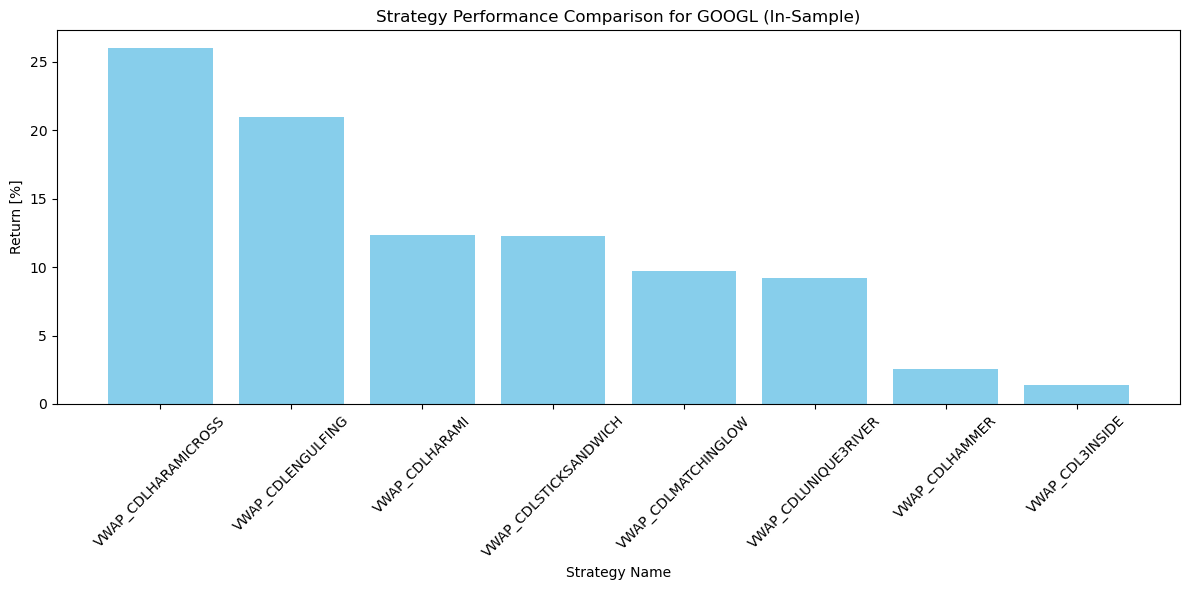

In [102]:
# 1. Strategy Performance Comparison
# plot strategy_name vs Return [%] (In-Sample)

# sort train_results by Return [%]
train_results = train_results.sort_values(by='Return [%]', ascending=False)

# keep only strategies with Return [%] greater than 0
train_results = train_results[train_results['Return [%]'] > 0]

# plot sorted bar chart
plt.figure(figsize=(12,6))
plt.bar(train_results['strategy_name'], train_results['Return [%]'], color='skyblue')
plt.xlabel('Strategy Name')
plt.ylabel('Return [%]')
plt.title('Strategy Performance Comparison for ' + ticker_name + ' (In-Sample)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

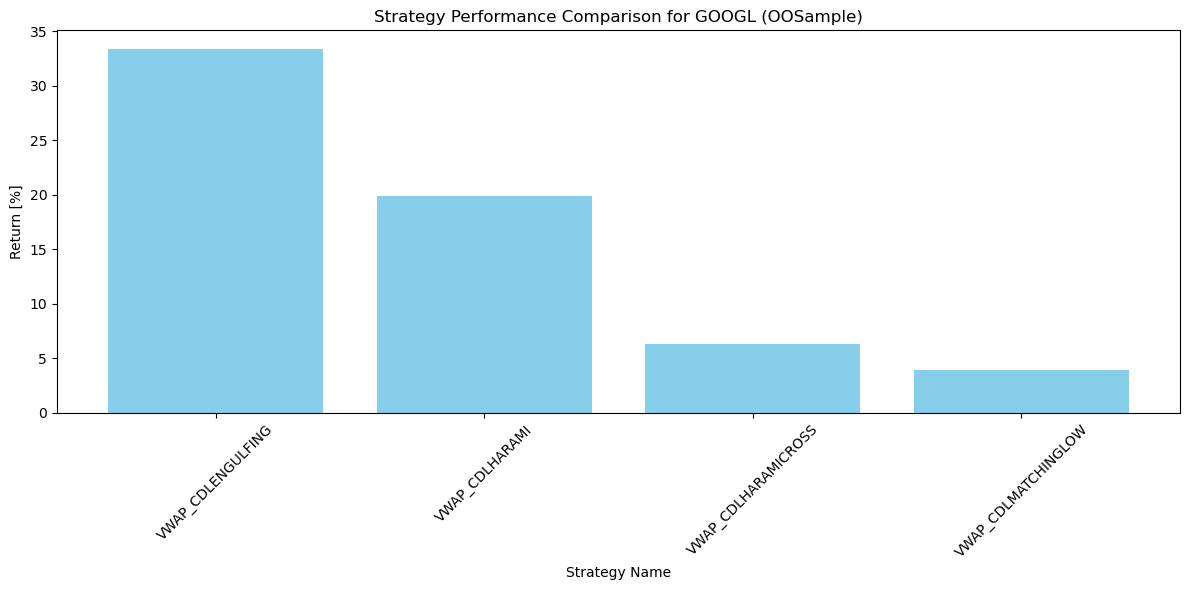

In [103]:
# 1. Strategy Performance Comparison
# plot strategy_name vs Return [%] (OOSample)

# sort train_results by Return [%]
oos_results = oos_results.sort_values(by='Return [%]', ascending=False)

# keep only strategies with Return [%] greater than 0
oos_results = oos_results[oos_results['Return [%]'] > 0]

# plot sorted bar chart
plt.figure(figsize=(12,6))
plt.bar(oos_results['strategy_name'], oos_results['Return [%]'], color='skyblue')
plt.xlabel('Strategy Name')
plt.ylabel('Return [%]')
plt.title('Strategy Performance Comparison for ' + ticker_name + ' (OOSample)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

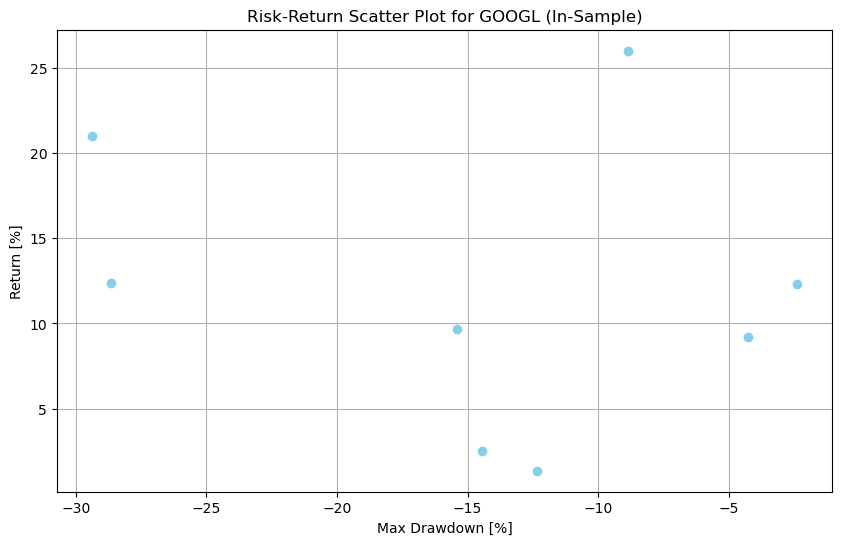

In [104]:
# 2. Risk-Return Scatter Plot (In-Sample)
# plot Max Drawdown [%] vs Return [%] from train_results
plt.figure(figsize=(10,6))
plt.scatter(train_results['Max. Drawdown [%]'], train_results['Return [%]'], color='skyblue')
plt.xlabel('Max Drawdown [%]')
plt.ylabel('Return [%]')
plt.title('Risk-Return Scatter Plot for ' + ticker_name + ' (In-Sample)')
plt.grid(True)
plt.show()

In [105]:
# # 2. Risk-Return Scatter Plot (In-Sample)
# # plot Max Drawdown [%] vs Return [%] from train_results using Plotly

# import plotly.express as px

# fig = px.scatter(
#     train_results, 
#     x='Max. Drawdown [%]', 
#     y='Return [%]', 
#     title='Risk-Return Scatter Plot for ' + ticker_name + ' (In-Sample)',
#     color_discrete_sequence=['skyblue']  # Match the original color
# )

# # Enable grid (Plotly has grid by default, but we can ensure it's visible)
# fig.update_layout(
#     xaxis=dict(showgrid=True),
#     yaxis=dict(showgrid=True)
# )

# fig.show()

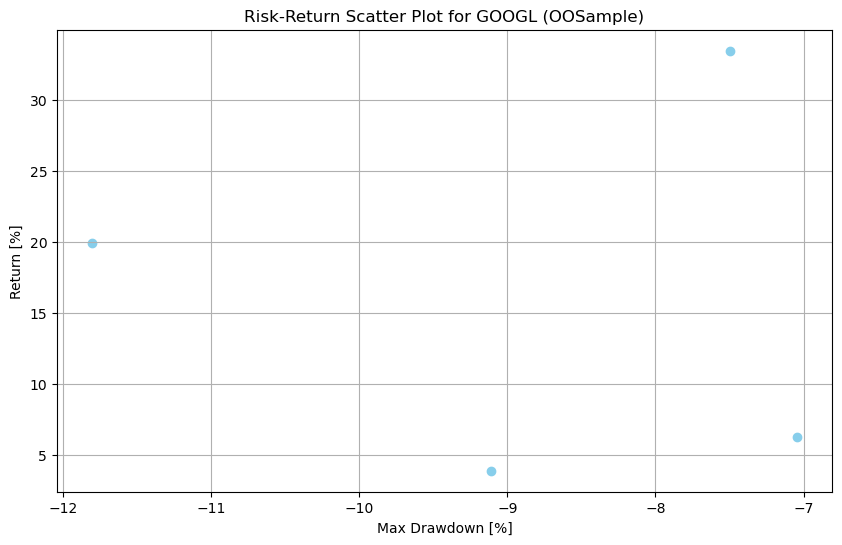

In [106]:
# 2. Risk-Return Scatter Plot (OOSample)
# plot Max Drawdown [%] vs Return [%] from oos_results
plt.figure(figsize=(10,6))
plt.scatter(oos_results['Max. Drawdown [%]'], oos_results['Return [%]'], color='skyblue')
plt.xlabel('Max Drawdown [%]')
plt.ylabel('Return [%]')
plt.title('Risk-Return Scatter Plot for ' + ticker_name + ' (OOSample)')
plt.grid(True)
plt.show()

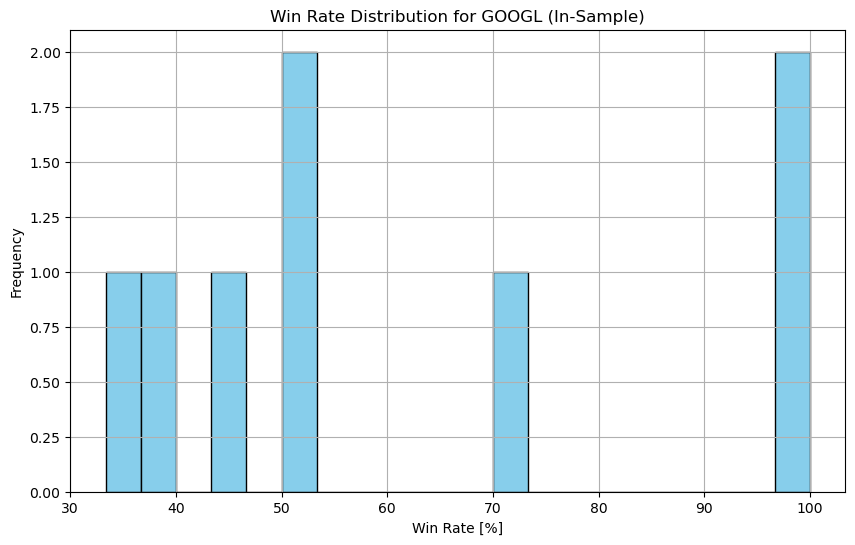

In [107]:
# 3. Win Rate Distribution (In-Sample)
# plot histogram of Win Rate [%] from train_results
plt.figure(figsize=(10,6))
plt.hist(train_results['Win Rate [%]'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Win Rate [%]')
plt.ylabel('Frequency')
plt.title('Win Rate Distribution for ' + ticker_name + ' (In-Sample)')
plt.grid(True)
plt.show()

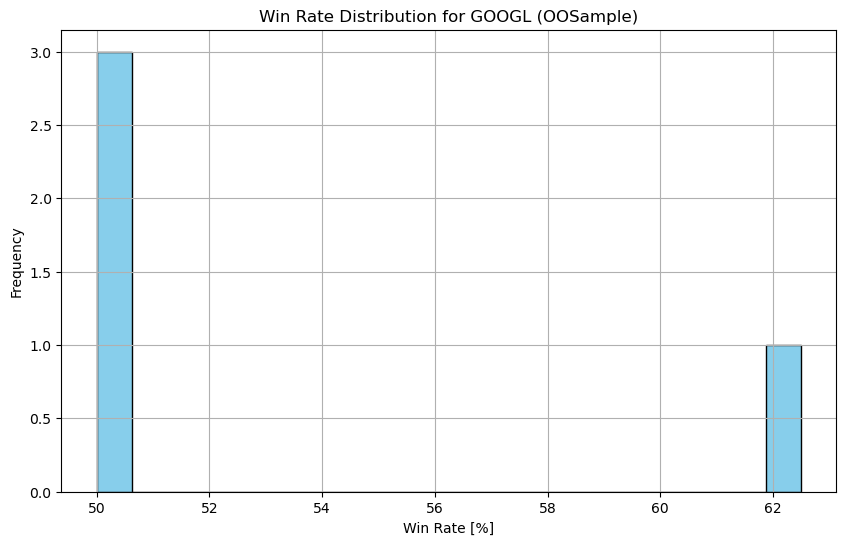

In [108]:
# 3. Win Rate Distribution (OOSample)
# plot histogram of Win Rate [%] from oos_results
plt.figure(figsize=(10,6))
plt.hist(oos_results['Win Rate [%]'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Win Rate [%]')
plt.ylabel('Frequency')
plt.title('Win Rate Distribution for ' + ticker_name + ' (OOSample)')
plt.grid(True)
plt.show()

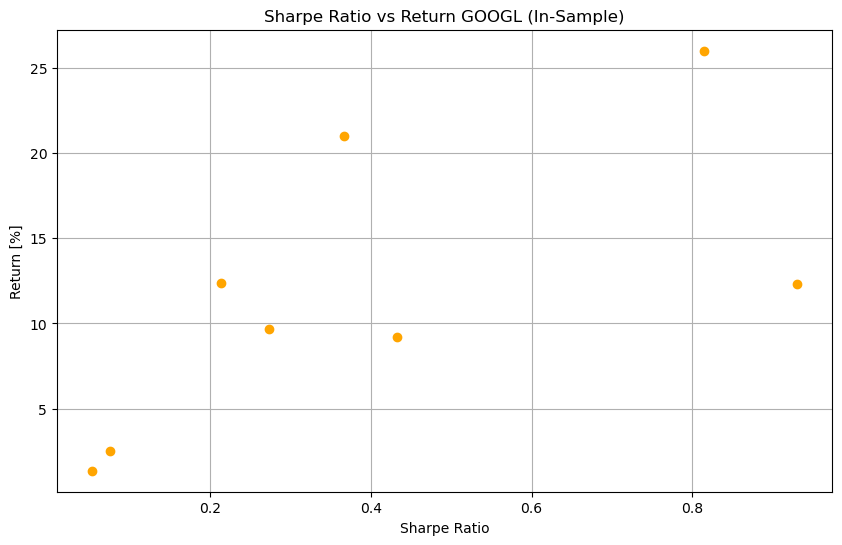

In [109]:
# 4. Sharpe Ratio vs Return (In-Sample)
# plot Sharpe Ratio vs Return [%] from train_results
plt.figure(figsize=(10,6))
plt.scatter(train_results['Sharpe Ratio'], train_results['Return [%]'], color='orange')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Return [%]')
plt.title('Sharpe Ratio vs Return ' + ticker_name + ' (In-Sample)')
plt.grid(True)
plt.show()

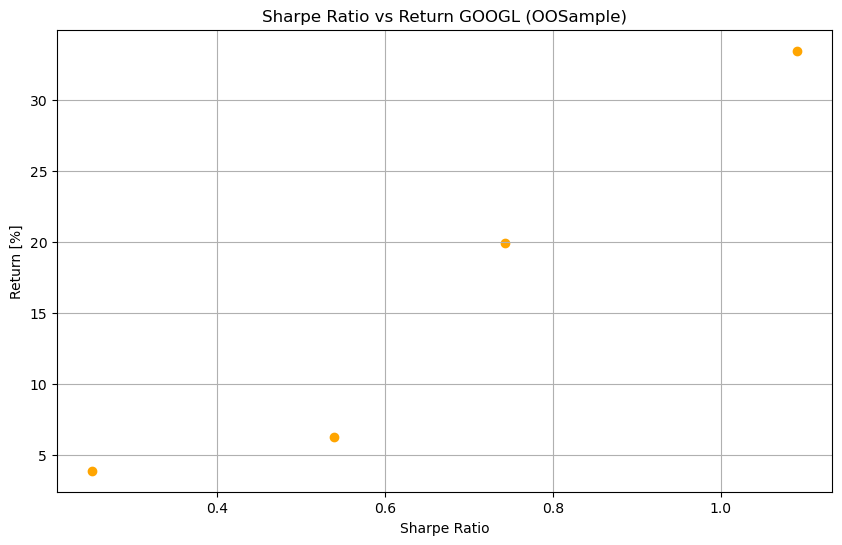

In [110]:
# 4. Sharpe Ratio vs Return (OOSample)
# plot Sharpe Ratio vs Return [%] from oos_results
plt.figure(figsize=(10,6))
plt.scatter(oos_results['Sharpe Ratio'], oos_results['Return [%]'], color='orange')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Return [%]')
plt.title('Sharpe Ratio vs Return ' + ticker_name + ' (OOSample)')
plt.grid(True)
plt.show()

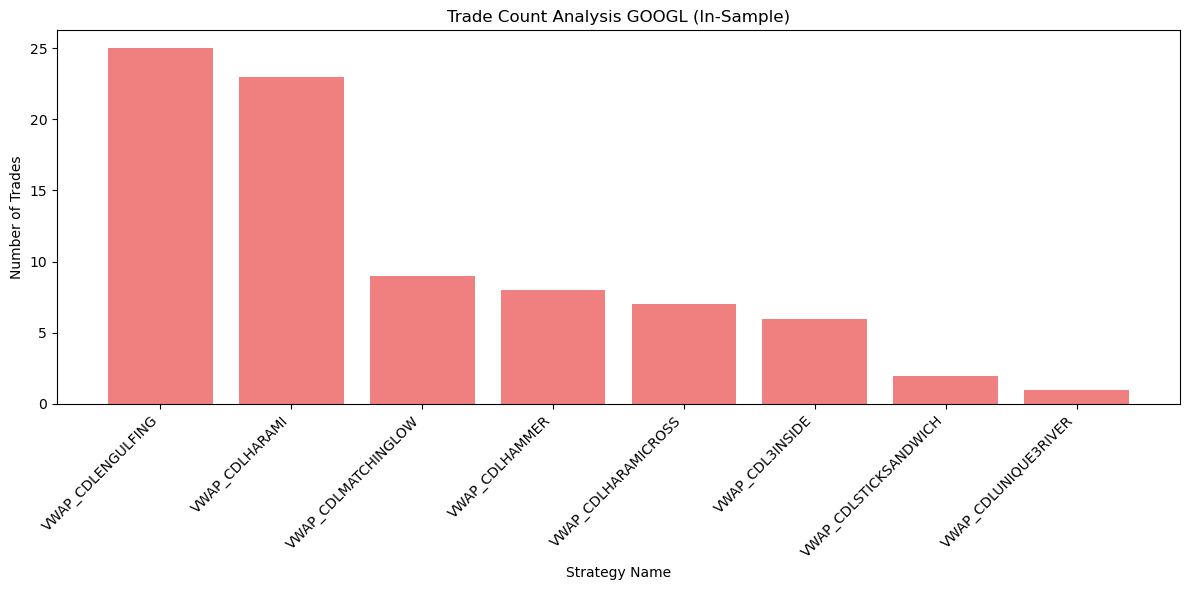

In [111]:
# 5. Trade Count Analysis (In-Sample)
# plot strategy_name vs # Trades from train_results

# sort train_results by # Trades
train_results = train_results.sort_values(by='# Trades', ascending=False)

plt.figure(figsize=(12,6))
plt.bar(train_results['strategy_name'], train_results['# Trades'], color='lightcoral')
plt.xlabel('Strategy Name')
plt.ylabel('Number of Trades')
plt.title('Trade Count Analysis ' + ticker_name + ' (In-Sample)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

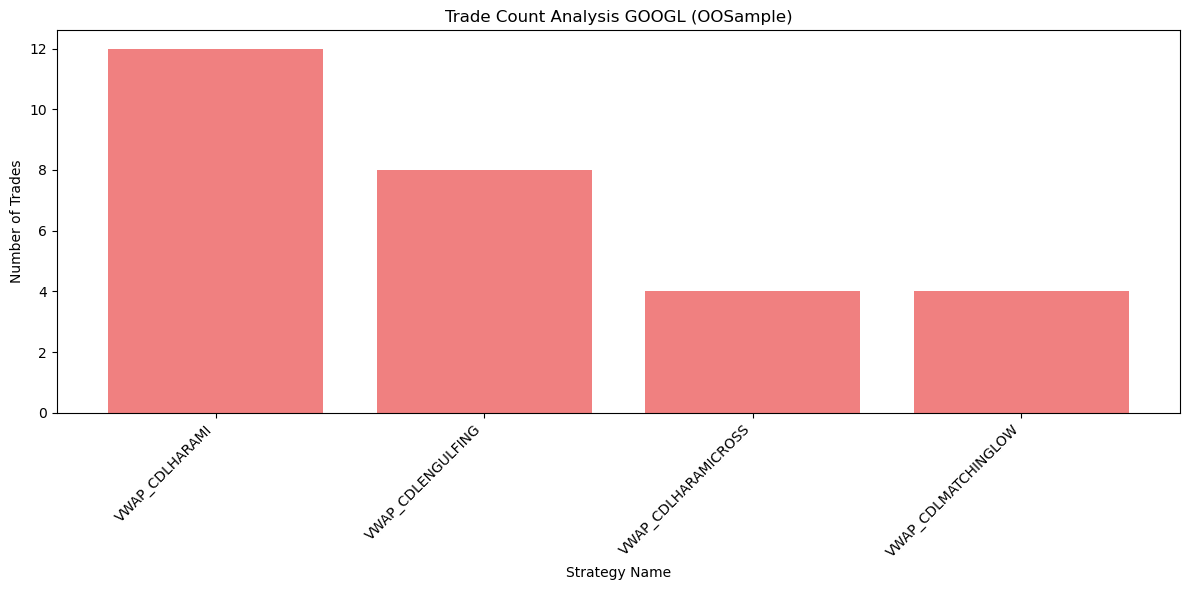

In [112]:
# 5. Trade Count Analysis (OOSample)
# plot strategy_name vs # Trades from oos_results

# sort oos_results by # Trades
oos_results = oos_results.sort_values(by='# Trades', ascending=False)

plt.figure(figsize=(12,6))
plt.bar(oos_results['strategy_name'], oos_results['# Trades'], color='lightcoral')
plt.xlabel('Strategy Name')
plt.ylabel('Number of Trades')
plt.title('Trade Count Analysis ' + ticker_name + ' (OOSample)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

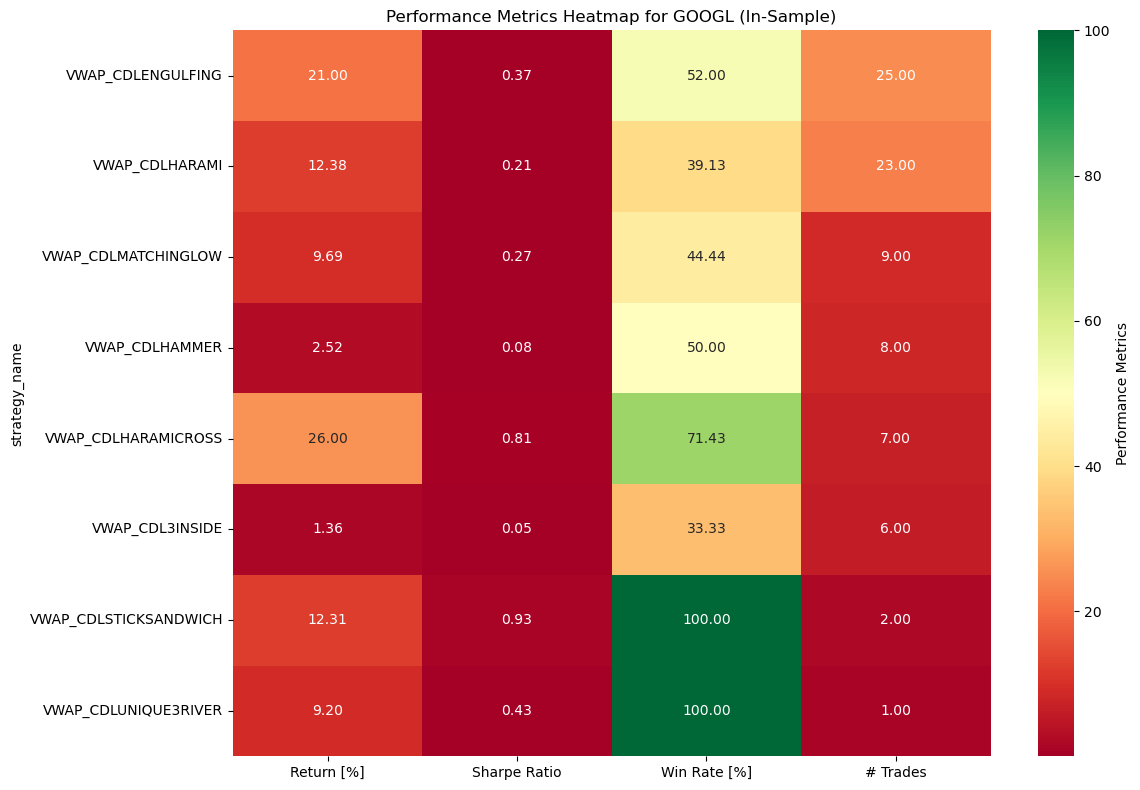

In [113]:
# 6. Performance Metrics Heatmap (In-Sample)
plt.figure(figsize=(12,8))

# select relevant columns   
metrics_df = train_results[['strategy_name', 'Return [%]', 'Sharpe Ratio', 'Win Rate [%]', '# Trades']]

metrics_df.set_index('strategy_name', inplace=True)
sns.heatmap(metrics_df, annot=True, fmt=".2f", cmap='RdYlGn', cbar_kws={'label': 'Performance Metrics'})
plt.title('Performance Metrics Heatmap for ' + ticker_name + ' (In-Sample)')
plt.tight_layout()
plt.show()

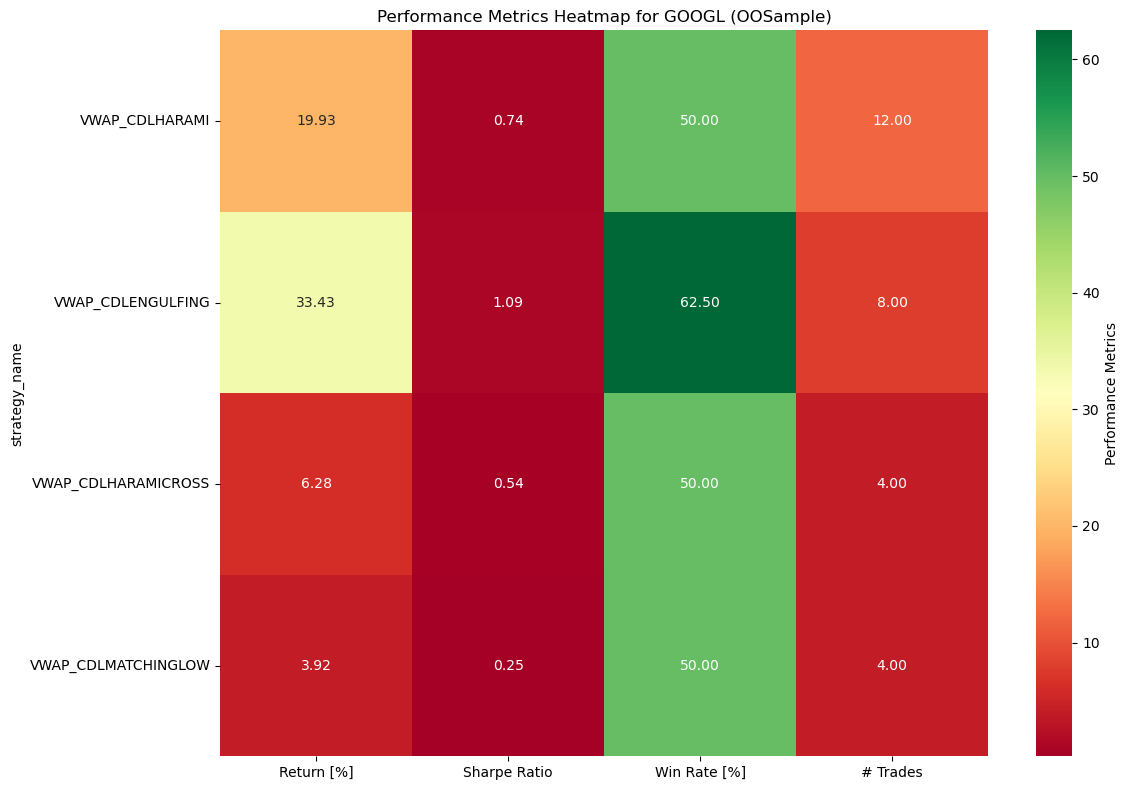

In [114]:
# 6. Performance Metrics Heatmap (OOSample)
if oos_results.empty:
    print("Skipping OOS bar chart: no out-of-sample strategies with positive returns.")
else:
    plt.figure(figsize=(12,8))

    # select relevant columns   
    metrics_df_oos = oos_results[['strategy_name', 'Return [%]', 'Sharpe Ratio', 'Win Rate [%]', '# Trades']]

    metrics_df_oos.set_index('strategy_name', inplace=True)
    sns.heatmap(metrics_df_oos, annot=True, fmt=".2f", cmap='RdYlGn', cbar_kws={'label': 'Performance Metrics'})
    plt.title('Performance Metrics Heatmap for ' + ticker_name + ' (OOSample)')
    plt.tight_layout()
    plt.show()

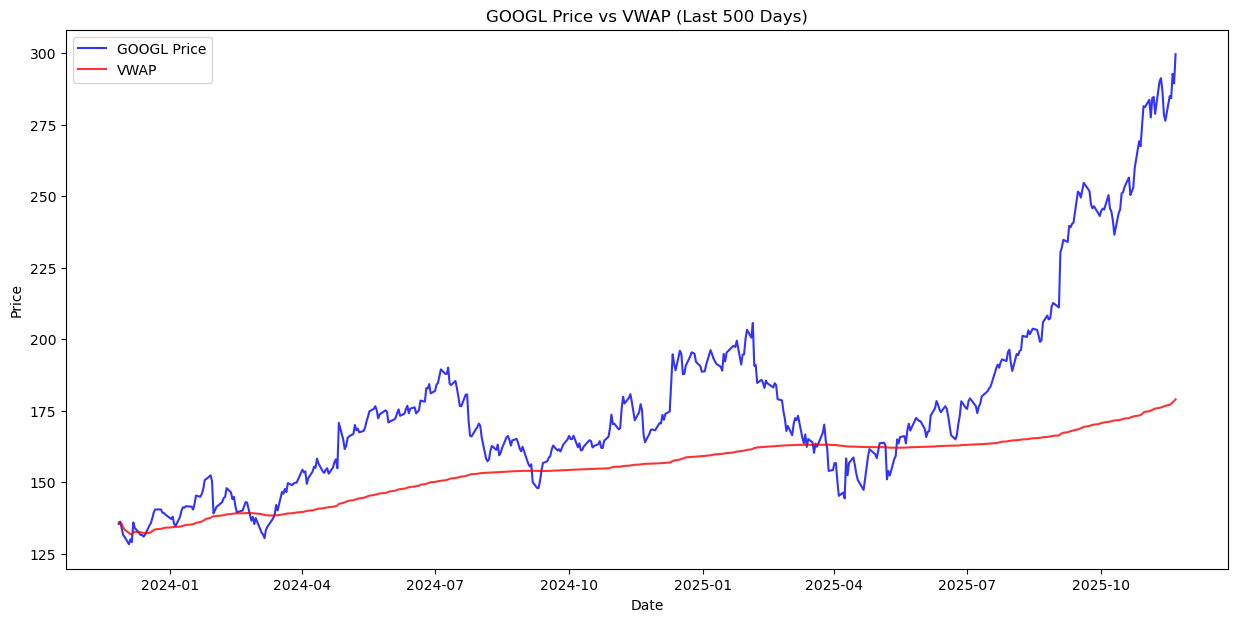

In [115]:
# 7. Price Chart with VWAP (Close prices of last 500 days)

# filter df_clean for last 500 days
df_last_500 = df_clean.tail(500)

# call calculate_vwap() function to add vwap column
df_last_500['vwap'] = calculate_vwap(df_last_500)

plt.figure(figsize=(15,7))

plt.plot(df_last_500.index, df_last_500['Close'], label=f'{ticker_name} Price', color='blue', alpha=0.8)
plt.plot(df_last_500.index, df_last_500['vwap'], label='VWAP', color='red', alpha=0.8)
plt.title(f'{ticker_name} Price vs VWAP (Last 500 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [116]:
# # Code working, just commented out to save space, graphics can be avoided if not needed
# # 8. Plot Trade statistics histogram (In-Sample) and (OOSample)
# """
# Statistics to plot:
#         '# Trades'
#         'Win Rate [%]'
#         'Avg. Trade [%]'
#         'Best Trade [%]'
#         'Worst Trade [%]'
# """
# plt.figure(figsize=(12,8))
# stats_to_plot = ['# Trades', 'Win Rate [%]', 'Avg. Trade [%]', 'Best Trade [%]', 'Worst Trade [%]']
# for i, stat in enumerate(stats_to_plot):
#     plt.subplot(3, 2, i+1)
#     plt.hist(train_results[stat], bins=20, color='skyblue', edgecolor='black')
#     plt.title(f'{stat} Distribution (In-Sample)')
#     plt.xlabel(stat)
#     plt.ylabel('Frequency')
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# for i, stat in enumerate(stats_to_plot):
#     plt.subplot(3, 2, i+1)
#     plt.hist(oos_results[stat], bins=20, color='skyblue', edgecolor='black')
#     plt.title(f'{stat} Distribution (OOSample)')
#     plt.xlabel(stat)
#     plt.ylabel('Frequency')
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

## 11. Monte Carlo Simulation and Robustness Testing

In [ ]:
def generate_synthetic_ohlc_data(original_data: pd.DataFrame, n_periods: int = None) -> pd.DataFrame:
    """
    Generate synthetic OHLC data based on original data statistics using geometric returns.
    
    Parameters:
    -----------
    original_data : pd.DataFrame
        Original OHLC data with columns: Open, High, Low, Close, Volume
    n_periods : int, optional
        Number of periods to generate. Defaults to length of original data.
        
    Returns:
    --------    pd.DataFrame
        Synthetic OHLC data with same structure as input
    """
    n_periods = n_periods or len(original_data)
    
    # Calculate statistical properties from original data
    returns = original_data['Close'].pct_change().dropna()
    vol_returns = original_data['Volume'].pct_change().dropna()
    
    mean_return = returns.mean()
    std_return = returns.std()
    mean_vol_return = vol_returns.mean()
    std_vol_return = vol_returns.std()
    
    # Generate random returns (no fixed seed for true Monte Carlo randomness)
    random_returns = np.random.normal(mean_return, std_return, n_periods)
    random_vol_returns = np.random.normal(mean_vol_return, std_vol_return, n_periods)
    
    # Initialize with first values from original data
    synthetic_close = [original_data['Close'].iloc[0]]
    synthetic_volume = [original_data['Volume'].iloc[0]]
    
    # Generate price and volume series
    for i in range(n_periods - 1):
        new_close = synthetic_close[-1] * (1 + random_returns[i])
        new_volume = max(100, synthetic_volume[-1] * (1 + random_vol_returns[i]))
        synthetic_close.append(new_close)
        synthetic_volume.append(new_volume)
    
    # Generate OHLC from close prices
    synthetic_data = []
    for close, volume in zip(synthetic_close, synthetic_volume):
        # Generate realistic intraday range (2% average)
        daily_range = abs(np.random.normal(0, close * 0.02))
        
        high = close + np.random.uniform(0, daily_range)
        low = close - np.random.uniform(0, daily_range)
        open_price = np.random.uniform(low, high)
        
        synthetic_data.append({
            'Open': open_price,
            'High': high,
            'Low': low,
            'Close': close,
            'Volume': volume
        })
    
    return pd.DataFrame(synthetic_data)


def run_monte_carlo_simulation(strategy_config: Dict, original_data: pd.DataFrame, 
                              n_simulations: int = 300) -> Dict:
    """
    Run Monte Carlo simulation for strategy robustness testing.
    
    Parameters:
    -----------
    strategy_config : Dict
        Strategy configuration dictionary
    original_data : pd.DataFrame
        Original OHLC data
    n_simulations : int
        Number of Monte Carlo simulations (default: 300)
        
    Returns:
    --------
    Dict
        Statistics from Monte Carlo simulations including return distribution,
        Sharpe ratio stats, and probability of positive returns
    """
    print(f"Running Monte Carlo simulation for {strategy_config['name']} ({n_simulations} simulations)...")
    
    results = []
    n_periods = min(len(original_data), 500)  # Limit to 500 periods for efficiency
    
    for i in range(n_simulations):
        try:
            # Generate synthetic data (different each time for true randomness)
            synthetic_data = generate_synthetic_ohlc_data(original_data, n_periods)
            
            # Run backtest on synthetic data
            result = run_single_backtest(strategy_config, synthetic_data)
            
            if result['success']:
                results.append({
                    'simulation': i + 1,
                    'return': result.get('Return [%]', 0),
                    'sharpe': result.get('Sharpe Ratio', 0),
                    'max_dd': result.get('Max Drawdown [%]', 0),
                    'trades': result.get('# Trades', 0),
                    'win_rate': result.get('Win Rate [%]', 0)
                })
            
            # Progress update every 50 simulations
            if (i + 1) % 50 == 0:
                print(f"  Completed {i + 1}/{n_simulations} simulations...")
                
        except Exception as e:
            continue  # Skip failed simulations
    
    if not results:
        return {'success': False, 'error': 'No successful simulations'}
    
    # Calculate comprehensive statistics
    returns = [r['return'] for r in results]
    sharpes = [r['sharpe'] for r in results if not pd.isna(r['sharpe']) and r['sharpe'] != 0]
    
    mc_stats = {
        'success': True,
        'n_successful_sims': len(results),
        'return_stats': {
            'mean': np.mean(returns),
            'std': np.std(returns),
            'min': np.min(returns),
            'max': np.max(returns),
            'percentile_5': np.percentile(returns, 5),
            'percentile_25': np.percentile(returns, 25),
            'percentile_50': np.percentile(returns, 50),
            'percentile_75': np.percentile(returns, 75),
            'percentile_95': np.percentile(returns, 95)
        },
        'sharpe_stats': {
            'mean': np.mean(sharpes) if sharpes else 0,
            'std': np.std(sharpes) if sharpes else 0,
            'min': np.min(sharpes) if sharpes else 0,
            'max': np.max(sharpes) if sharpes else 0
        },
        'positive_return_probability': len([r for r in returns if r > 0]) / len(results),
        'raw_results': results
    }
    
    print(f"\nMonte Carlo completed: {len(results)} successful simulations")
    print(f"Mean return: {mc_stats['return_stats']['mean']:.2f}% ± {mc_stats['return_stats']['std']:.2f}%")
    print(f"Return range: [{mc_stats['return_stats']['percentile_5']:.2f}%, {mc_stats['return_stats']['percentile_95']:.2f}%] (90% CI)")
    print(f"Positive return probability: {mc_stats['positive_return_probability']:.2%}")
    if sharpes:
        print(f"Mean Sharpe ratio: {mc_stats['sharpe_stats']['mean']:.3f} ± {mc_stats['sharpe_stats']['std']:.3f}")
    
    return mc_stats


# Execute Monte Carlo simulation on best strategy
if len(train_results) > 0:
    best_strategy_name = train_results.loc[train_results['Return [%]'].idxmax(), 'strategy_name']
    best_config = next(
        (config for config in strategy_configs if config['name'] == best_strategy_name),
        None
    )
    
    if best_config:
        # Prepare data in correct format
        mc_data = df_clean[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
        
        print(f"Starting Monte Carlo simulation for best strategy: {best_strategy_name}\n")
        
        # Run single comprehensive Monte Carlo simulation with 300 runs
        mc_results = run_monte_carlo_simulation(best_config, mc_data, n_simulations=300)
        
        if mc_results.get('success', False):
            print(f"\n{'='*60}")
            print("MONTE CARLO SIMULATION SUMMARY")
            print(f"{'='*60}")
            print(f"Strategy: {best_strategy_name}")
            print(f"Successful simulations: {mc_results['n_successful_sims']}/300")
            print(f"\nReturn Statistics:")
            print(f"  Mean: {mc_results['return_stats']['mean']:.2f}%")
            print(f"  Std Dev: {mc_results['return_stats']['std']:.2f}%")
            print(f"  Median: {mc_results['return_stats']['percentile_50']:.2f}%")
            print(f"  5th-95th percentile: [{mc_results['return_stats']['percentile_5']:.2f}%, {mc_results['return_stats']['percentile_95']:.2f}%]")
            print(f"\nRobustness Metrics:")
            print(f"  Positive return probability: {mc_results['positive_return_probability']:.2%}")
            if mc_results['sharpe_stats']['mean'] != 0:
                print(f"  Mean Sharpe ratio: {mc_results['sharpe_stats']['mean']:.3f}")
        else:
            print(f"Monte Carlo simulation failed: {mc_results.get('error', 'Unknown error')}")
else:
    print("No strategies available for Monte Carlo simulation")

Starting Monte Carlo simulation for best strategy: VWAP_CDLHARAMICROSS

Running Monte Carlo simulation for VWAP_CDLHARAMICROSS (300 simulations)...
  Completed 50/300 simulations...
  Completed 100/300 simulations...
  Completed 150/300 simulations...
  Completed 200/300 simulations...
  Completed 250/300 simulations...
  Completed 300/300 simulations...

Monte Carlo completed: 300 successful simulations
Mean return: 1.71% ± 12.48%
Return range: [-16.87%, 22.96%] (90% CI)
Positive return probability: 48.67%

MONTE CARLO SIMULATION SUMMARY
Strategy: VWAP_CDLHARAMICROSS
Successful simulations: 300/300

Return Statistics:
  Mean: 1.71%
  Std Dev: 12.48%
  Median: 0.00%
  5th-95th percentile: [-16.87%, 22.96%]

Robustness Metrics:
  Positive return probability: 48.67%


In [118]:
# check again def plot_monte_carlo_results(mc_results: Dict, strategy_name: str) -> None:
# not included anymore in cell 33
# take from cell 35

In [119]:
# def generate_synthetic_ohlc_data(original_data: pd.DataFrame, n_periods: int = None) -> pd.DataFrame:
#     """
#     Generate synthetic OHLC data based on original data statistics
#     """
#     if n_periods is None:
#         n_periods = len(original_data)
    
#     # Calculate returns and volatilities from original data
#     returns = original_data['close'].pct_change().dropna()
#     vol_returns = original_data['volume'].pct_change().dropna()
    
#     # Get statistical properties
#     mean_return = returns.mean()
#     std_return = returns.std()
#     mean_vol_return = vol_returns.mean()
#     std_vol_return = vol_returns.std()
    
#     # Generate random returns
#     np.random.seed(42)
#     random_returns = np.random.normal(mean_return, std_return, n_periods)
#     random_vol_returns = np.random.normal(mean_vol_return, std_vol_return, n_periods)
    
#     # Start with initial values from original data
#     initial_close = original_data['close'].iloc[0]
#     initial_volume = original_data['volume'].iloc[0]
    
#     # Generate synthetic price series
#     synthetic_close = [initial_close]
#     synthetic_volume = [initial_volume]
    
#     for i in range(n_periods - 1):
#         new_close = synthetic_close[-1] * (1 + random_returns[i])
#         new_volume = max(100, synthetic_volume[-1] * (1 + random_vol_returns[i]))  # Ensure positive volume
#         synthetic_close.append(new_close)
#         synthetic_volume.append(new_volume)
    
#     # Generate OHLC from close prices
#     synthetic_data = []
#     for i in range(len(synthetic_close)):
#         close = synthetic_close[i]
#         # Generate realistic OHLC based on close price with some randomness
#         daily_range = abs(np.random.normal(0, close * 0.02))  # 2% average daily range
        
#         high = close + np.random.uniform(0, daily_range)
#         low = close - np.random.uniform(0, daily_range)
        
#         # Ensure open is between high and low
#         open_price = np.random.uniform(low, high)
        
#         synthetic_data.append({
#             'Open': open_price,
#             'High': high,
#             'Low': low,
#             'Close': close,
#             'Volume': synthetic_volume[i]
#         })
    
#     return pd.DataFrame(synthetic_data)

# def run_monte_carlo_simulation(strategy_config: Dict, original_data: pd.DataFrame, 
#                               n_simulations: int = 100, random_seed: int = 42) -> Dict:
#     """
#     Run Monte Carlo simulation for strategy robustness testing
#     """
#     np.random.seed(random_seed)
#     random.seed(random_seed)
    
#     print(f"Running Monte Carlo simulation for {strategy_config['name']} ({n_simulations} runs)...")
    
#     results = []
#     n_periods = min(len(original_data), 500)  # Use up to 500 periods for efficiency
    
#     for i in range(n_simulations):
#         try:
#             # Generate synthetic data with different seed for each simulation
#             np.random.seed(random_seed + i)
#             random.seed(random_seed + i)
            
#             # Generate synthetic OHLC data
#             synthetic_data = generate_synthetic_ohlc_data(original_data, n_periods)
            
#             # Run backtest on synthetic data
#             result = run_single_backtest(strategy_config, synthetic_data)
            
#             if result['success']:
#                 results.append({
#                     'simulation': i + 1,
#                     'return': result.get('Return [%]', 0),
#                     'sharpe': result.get('Sharpe Ratio', 0),
#                     'max_dd': result.get('Max Drawdown [%]', 0),
#                     'trades': result.get('# Trades', 0),
#                     'win_rate': result.get('Win Rate [%]', 0)
#                 })
            
#             if (i + 1) % 20 == 0:
#                 print(f"  Completed {i + 1}/{n_simulations} simulations...")
                
#         except Exception as e:
#             # Skip failed simulations
#             continue
    
#     if len(results) == 0:
#         return {'success': False, 'error': 'No successful simulations'}
    
#     # Calculate statistics
#     returns = [r['return'] for r in results]
#     sharpes = [r['sharpe'] for r in results if not pd.isna(r['sharpe']) and r['sharpe'] != 0]
    
#     mc_stats = {
#         'success': True,
#         'n_successful_sims': len(results),
#         'return_stats': {
#             'mean': np.mean(returns),
#             'std': np.std(returns),
#             'min': np.min(returns),
#             'max': np.max(returns),
#             'percentile_5': np.percentile(returns, 5),
#             'percentile_95': np.percentile(returns, 95)
#         },
#         'sharpe_stats': {
#             'mean': np.mean(sharpes) if sharpes else 0,
#             'std': np.std(sharpes) if sharpes else 0,
#         },
#         'positive_return_probability': len([r for r in returns if r > 0]) / len(returns),
#         'raw_results': results
#     }
    
#     print(f"Monte Carlo completed: {len(results)} successful simulations")
#     print(f"Mean return: {mc_stats['return_stats']['mean']:.2f}% ± {mc_stats['return_stats']['std']:.2f}%")
#     print(f"Positive return probability: {mc_stats['positive_return_probability']:.2%}")
    
#     return mc_stats

# def plot_monte_carlo_results(mc_results: Dict, strategy_name: str) -> None:
#     """
#     Plot Monte Carlo simulation results
#     """
#     if not mc_results.get('success', False):
#         print("No Monte Carlo results to plot")
#         return
    
#     fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
#     results = mc_results['raw_results']
#     returns = [r['return'] for r in results]
#     sharpes = [r['sharpe'] for r in results if not pd.isna(r['sharpe']) and r['sharpe'] != 0]
    
#     # 1. Return distribution
#     ax1.hist(returns, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
#     ax1.axvline(np.mean(returns), color='red', linestyle='--', 
#                label=f'Mean: {np.mean(returns):.2f}%')
#     ax1.axvline(0, color='black', linestyle='-', alpha=0.5)
#     ax1.set_xlabel('Return (%)')
#     ax1.set_ylabel('Frequency')
#     ax1.set_title('Monte Carlo Return Distribution')
#     ax1.legend()
#     ax1.grid(True, alpha=0.3)
    
#     # 2. Cumulative return probability
#     sorted_returns = np.sort(returns)
#     cumprob = np.arange(1, len(sorted_returns) + 1) / len(sorted_returns)
    
#     ax2.plot(sorted_returns, cumprob, color='green', linewidth=2)
#     ax2.axvline(0, color='red', linestyle='--', alpha=0.7, label='Break-even')
#     ax2.set_xlabel('Return (%)')
#     ax2.set_ylabel('Cumulative Probability')
#     ax2.set_title('Cumulative Return Probability')
#     ax2.legend()
#     ax2.grid(True, alpha=0.3)
    
#     # 3. Sharpe ratio distribution (if available)
#     if sharpes and len(sharpes) > 1:
#         ax3.hist(sharpes, bins=20, alpha=0.7, color='orange', edgecolor='black')
#         ax3.axvline(np.mean(sharpes), color='red', linestyle='--',
#                    label=f'Mean: {np.mean(sharpes):.2f}')
#         ax3.set_xlabel('Sharpe Ratio')
#         ax3.set_ylabel('Frequency')
#         ax3.set_title('Sharpe Ratio Distribution')
#         ax3.legend()
#         ax3.grid(True, alpha=0.3)
#     else:
#         ax3.text(0.5, 0.5, 'Insufficient Sharpe Ratio Data', ha='center', va='center', 
#                 transform=ax3.transAxes, fontsize=14)
#         ax3.set_title('Sharpe Ratio Distribution')
    
#     # 4. Risk-return scatter
#     max_dds = [abs(r['max_dd']) for r in results]
#     ax4.scatter(max_dds, returns, alpha=0.6, color='purple')
#     ax4.set_xlabel('Max Drawdown (%)')
#     ax4.set_ylabel('Return (%)')
#     ax4.set_title('Risk vs Return')
#     ax4.grid(True, alpha=0.3)
    
#     plt.suptitle(f'Monte Carlo Analysis: {strategy_name}', fontsize=16, fontweight='bold')
#     plt.tight_layout()
#     plt.show()

# # Run Monte Carlo simulation on best strategy
# if len(train_results) > 0:
#     best_strategy_name = train_results.loc[train_results['Return [%]'].idxmax(), 'strategy_name']
#     best_config = next(
#         (config for config in strategy_configs if config['name'] == best_strategy_name),
#         None
#     )
    
#     if best_config:
#         # Prepare data in correct format for Monte Carlo
#         mc_data = df_clean[['open', 'high', 'low', 'close', 'volume']].copy()
        
#         print(f"Starting Monte Carlo simulation for best strategy: {best_strategy_name}")
#         mc_results = run_monte_carlo_simulation(best_config, mc_data, n_simulations=50)
        
#         if mc_results.get('success', False):
#             plot_monte_carlo_results(mc_results, best_strategy_name)
#         else:
#             print(f"Monte Carlo simulation failed: {mc_results.get('error', 'Unknown error')}")
# else:
#     print("No strategies available for Monte Carlo simulation")

## 12. Multi-Timeframe Analysis

### Preparing Data

In [120]:
"""
The following cells should be uncommented when running the full notebook end-to-end
""" 

'\nThe following cells should be uncommented when running the full notebook end-to-end\n'

In [121]:
## Inserted - just to mark the spot and avoid running full code ----

### Data Preprocessing - 1H Timeframe

In [122]:
import yfinance as yf

def download_data_1h(ticker_name, period="max", interval="1h", save_path=None):
    """
    Download 1-hour historical stock data from Yahoo Finance and save to CSV.
    """
    print(f"=== DOWNLOADING 1H DATA for {ticker_name} ===")

    try:
        data = yf.download(ticker_name, period=period, interval=interval)
        if data.empty:
            print("ERROR: No data retrieved.")
            return None, None
    except Exception as e:
        print(f"Download failed: {e}")
        return None, None

    # Build filename
    end_date_str = datetime.now().strftime("%Y-%m-%d")
    filename = save_path or f"data_{ticker_name}_{end_date_str}_1h.csv"
    full_path = os.path.join(os.getcwd(), filename)

    try:
        data.to_csv(full_path)
        print(f"Data saved")
    except Exception as e:
        print(f"Error saving CSV: {e}")
        return data, None

    print(f"Shape: {data.shape}, Range: {data.index.min()} → {data.index.max()}")
    return data, full_path


In [123]:
def load_market_data_1h(ticker_name, force_download=False):
    """
    Load 1-hour market data for a ticker.
    Downloads if CSV doesn't exist or force_download=True.
    """
    end_date_str = datetime.now().strftime("%Y-%m-%d")
    filename = f"data_{ticker_name}_{end_date_str}_1h.csv"

    if force_download or not os.path.exists(filename):
        print("Downloading fresh 1-hour data...")
        df, saved_file = download_data_1h(ticker_name)
        if df is None:
            return None
    else:
        print(f"Loading existing file: {filename}")
        df = pd.read_csv(filename, header=[0,1], index_col=0, parse_dates=True)

    df = df.dropna(how='all')
    # df.columns = [c.capitalize() for c in df.columns]

    print(f"Data loaded: {df.shape} rows, from {df.index.min()} to {df.index.max()}")
    return df


In [124]:
# === Test load ===
# ticker_name = "NVDA"
df1h = load_market_data_1h(ticker_name)

if df1h is not None:
    print("\nData loaded successfully:")
    print(df1h.tail(3))
else:
    print("Loading failed.")


=== DOWNLOADING 1H DATA for GOOGL ===


[*********************100%***********************]  1 of 1 completed

Data saved
Shape: (3484, 5), Range: 2023-11-27 14:30:00+00:00 → 2025-11-21 20:30:00+00:00
Data loaded: (3484, 5) rows, from 2023-11-27 14:30:00+00:00 to 2025-11-21 20:30:00+00:00

Data loaded successfully:
Price                           Close        High         Low        Open  \
Ticker                          GOOGL       GOOGL       GOOGL       GOOGL   
Datetime                                                                    
2025-11-21 18:30:00+00:00  302.610107  303.920013  296.660004  296.859985   
2025-11-21 19:30:00+00:00  299.769989  302.899994  299.769989  302.500000   
2025-11-21 20:30:00+00:00  299.739990  301.369995  298.880005  299.769989   

Price                       Volume  
Ticker                       GOOGL  
Datetime                            
2025-11-21 18:30:00+00:00  6533518  
2025-11-21 19:30:00+00:00  3607158  
2025-11-21 20:30:00+00:00  4256627  


In [125]:
"""
Function that select the best 2 strategy_name based on out-of-sample results
"""
def select_best_oos_strategy(oos_results: pd.DataFrame) -> str:
    """
    Select the best strategy based on out-of-sample results
    Criteria: Highest Return [%], then highest Sharpe Ratio
    """
    if oos_results.empty:
        print("No out-of-sample results available")
        return None
    
    # Filter successful strategies
    successful_strategies = oos_results[oos_results['success'] == True]
    
    if successful_strategies.empty:
        print("No successful out-of-sample strategies")
        return None
    
    # Sort by Return [%] descending, then Sharpe Ratio descending
    sorted_strategies = successful_strategies.sort_values(
        by=['Return [%]', 'Sharpe Ratio'], 
        ascending=[False, False]
    )

    best_strategy_name = sorted_strategies.iloc[:2]['strategy_name']

    return best_strategy_name.tolist()

# call the function
best_oos_strategy = select_best_oos_strategy(oos_results)


In [126]:
"""
Function that select the best 2 strategy_name based on in-sample results
"""
def select_best_in_sample_strategy(train_results: pd.DataFrame) -> str:
    """
    Select the best strategy based on in-sample results
    Criteria: Highest Return [%], then highest Sharpe Ratio
    """
    if train_results.empty:
        print("No in-sample results available")
        return None
    
    # Filter successful strategies
    successful_strategies = train_results[train_results['success'] == True]
    
    if successful_strategies.empty:
        print("No successful in-sample strategies")
        return None
    
    # Sort by Return [%] descending, then Sharpe Ratio descending
    sorted_strategies = successful_strategies.sort_values(
        by=['Return [%]', 'Sharpe Ratio'], 
        ascending=[False, False]
    )

    best_strategy_name = sorted_strategies.iloc[:2]['strategy_name']

    return best_strategy_name.tolist()

# call the function
best_in_sample_strategies = select_best_in_sample_strategy(train_results)

In [127]:
print(f"Best out-of-sample strategies selected: {best_oos_strategy}")
print(f"Best in-sample strategies selected: {best_in_sample_strategies}")

Best out-of-sample strategies selected: ['VWAP_CDLENGULFING', 'VWAP_CDLHARAMI']
Best in-sample strategies selected: ['VWAP_CDLHARAMICROSS', 'VWAP_CDLENGULFING']


In [128]:
"""
add to compare_strategy_lists() here below, if list best_oos_strategy is empty, return None
"""

'\nadd to compare_strategy_lists() here below, if list best_oos_strategy is empty, return None\n'

In [129]:
"""
Function that compare two lists, best_oos_strategy and best_in_sample_strategies, and remove the overlap 
strategies (if any). Return one final list with each unique strategy appearing only once.
"""
def compare_strategy_lists(best_oos_strategy: list, best_in_sample_strategies: list) -> list:
    # Create a set to track unique strategies
    seen = set()
    final_strategies = []
    
    # Add strategies from best_oos_strategy first (giving priority to OOS strategies)
    for strategy in best_oos_strategy:
        if strategy not in seen:
            final_strategies.append(strategy)
            seen.add(strategy)
    
    # Add strategies from best_in_sample_strategies only if not already added
    for strategy in best_in_sample_strategies:
        if strategy not in seen:
            final_strategies.append(strategy)
            seen.add(strategy)
    
    return final_strategies

final_selected_strategies = compare_strategy_lists(best_oos_strategy, best_in_sample_strategies)
print(f"Final selected strategies after removing overlaps: {final_selected_strategies}")

Final selected strategies after removing overlaps: ['VWAP_CDLENGULFING', 'VWAP_CDLHARAMI', 'VWAP_CDLHARAMICROSS']


In [130]:
def backtest_final_strategies(final_selected_strategies, df1h, cash=100000, commission=0.002):
    """
    Backtest final selected strategies using clean OHLCV data.
    Automatically fixes column name and dtype issues.
    """

    print(f"Backtesting {len(final_selected_strategies)} strategies...")
    print(f"Data shape: {df1h.shape}")

    # === 1. Clean and normalize column names ===
    df = df1h.copy()

    # Handle MultiIndex columns (like ('Open', 'AAPL'))
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

    # df.columns = [c.lower() for c in df.columns]

    # Filter only valid OHLCV columns
    valid_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    df = df[[c for c in valid_cols if c in df.columns]]

    if df.empty:
        print("ERROR: No valid OHLCV columns found.")
        print("Available columns:", list(df1h.columns))
        return None

    # === 2. Remove non-numeric data and convert to float ===
    df = df.apply(pd.to_numeric, errors='coerce')  # turns invalid text into NaN
    df = df.dropna(subset=['Open', 'High', 'Low', 'Close'])  # require numeric prices

    # === 3. Ensure DatetimeIndex ===
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, errors='coerce')
        df = df[~df.index.isna()]  # drop rows with invalid or NaT index

    # === 4. Rename columns to match Backtesting.py ===
    # df.columns = [c.capitalize() for c in df.columns]

    # === 5. Validate and preview ===
    print(f"Final cleaned data: {df.shape}")
    print(df.head(3))
    print(f"Date range: {df.index.min()} → {df.index.max()}")
    print(f"Columns: {list(df.columns)}")

    results = []

    # === 6. Run backtests ===
    for i, name in enumerate(final_selected_strategies, 1):
        print(f"\n({i}/{len(final_selected_strategies)}) Testing {name}...")

        try:
            config = next((cfg for cfg in strategy_configs if cfg['name'] == name), None)
            if not config:
                print("Config not found.")
                results.append({'strategy_name': name, 'Return [%]': 0, 'success': False})
                continue

            StrategyClass = create_vwap_strategy_class(
                pattern_name=config['pattern_function'],
                atr_period=config['atr_period'],
                sl_multiplier=config['sl_multiplier'],
                tp_multiplier=config['tp_multiplier']
            )

            bt = Backtest(
                df,
                StrategyClass,
                cash=cash,
                commission=commission,
                finalize_trades=True  # close open trades at backtest end to avoid warnings
            )
            res = bt.run()

            results.append({
                'strategy_name': name,
                'Return [%]': res['Return [%]'],
                '# Trades': res['# Trades'],
                'Win Rate [%]': res.get('Win Rate [%]', 0),
                'Sharpe Ratio': res.get('Sharpe Ratio', 0),
                'Max. Drawdown [%]': res.get('Max. Drawdown [%]', 0),
                'success': True
            })

            print(f"SUCCESS: Return {res['Return [%]']:.2f}% | Trades {res['# Trades']}")

        except Exception as e:
            print(f"FAILED: {e}")
            traceback.print_exc()
            results.append({'strategy_name': name, 'Return [%]': 0, 'success': False})

    # === 7. Summarize ===
    results_df_1h = pd.DataFrame(results)
    print("\n=== BACKTEST SUMMARY ===")
    print(results_df_1h)

    success = results_df_1h[results_df_1h['success']]
    if not success.empty:
        best = success.loc[success['Return [%]'].idxmax()]
        print(f"\nBest strategy: {best['strategy_name']} → {best['Return [%]']:.2f}%")
    else:
        print("No successful strategies.")

    return results_df_1h


In [131]:
if 'final_selected_strategies' in locals() and len(final_selected_strategies) > 0:
    if 'df1h' in locals():
        final_backtest_results = backtest_final_strategies(final_selected_strategies, df1h)
    else:
        print("ERROR: df1h not found. Please load data first.")
else:
    print("ERROR: final_selected_strategies not found.")


Backtesting 3 strategies...
Data shape: (3484, 5)
Final cleaned data: (3484, 5)
                                 Open        High         Low       Close  \
Datetime                                                                    
2023-11-27 14:30:00+00:00  137.679993  138.419998  136.350006  136.539993   
2023-11-27 15:30:00+00:00  136.550003  136.979996  136.115005  136.419998   
2023-11-27 16:30:00+00:00  136.419998  136.804993  136.375000  136.675003   

                            Volume  
Datetime                            
2023-11-27 14:30:00+00:00  6656708  
2023-11-27 15:30:00+00:00  2080938  
2023-11-27 16:30:00+00:00  1691636  
Date range: 2023-11-27 14:30:00+00:00 → 2025-11-21 20:30:00+00:00
Columns: ['Open', 'High', 'Low', 'Close', 'Volume']

(1/3) Testing VWAP_CDLENGULFING...
SUCCESS: Return -13.01% | Trades 116

(2/3) Testing VWAP_CDLHARAMI...
SUCCESS: Return -14.50% | Trades 87

(3/3) Testing VWAP_CDLHARAMICROSS...
SUCCESS: Return 3.08% | Trades 24

=== BACKTEST SUM

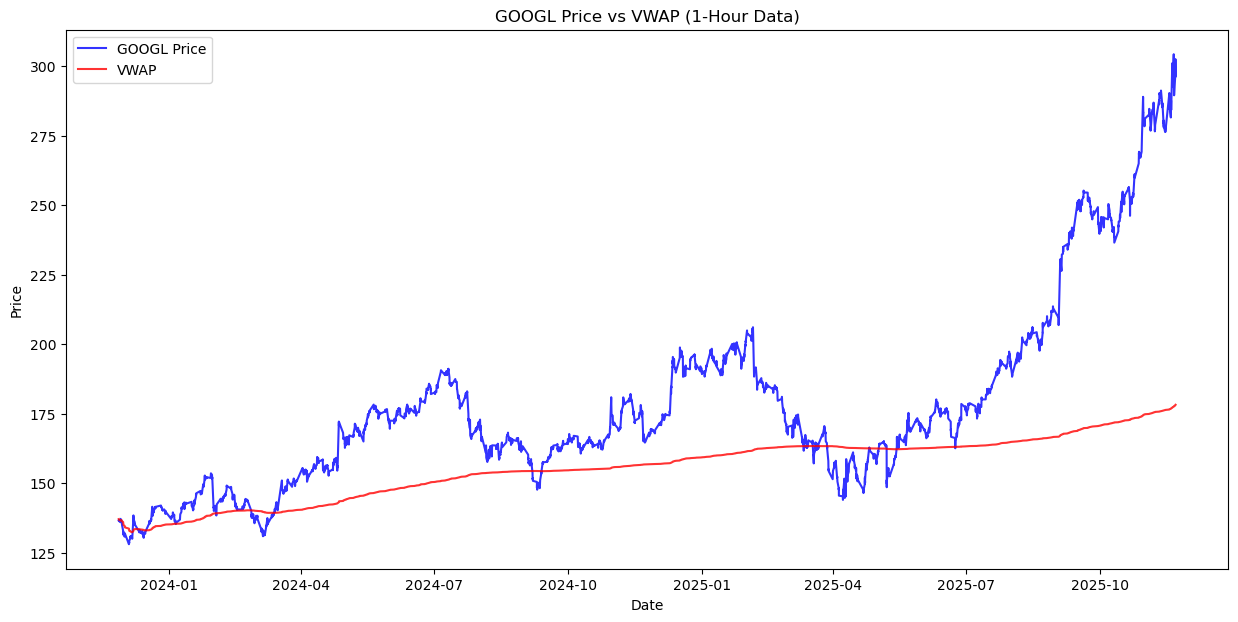

In [132]:
# plot close prices from df1h with vwap overlay
# calculate vwap
df1h['vwap'] = calculate_vwap(df1h)

plt.figure(figsize=(15,7))
plt.plot(df1h.index, df1h['Close'], label=f'{ticker_name} Price', color='blue', alpha=0.8)
plt.plot(df1h.index, df1h['vwap'], label='VWAP', color='red', alpha=0.8)
plt.title(f'{ticker_name} Price vs VWAP (1-Hour Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Data Preprocessing - 4H Timeframe

In [133]:
import yfinance as yf

def download_data_4h(ticker_name, period="730d", interval="4h", save_path=None):
    """
    Download 4-hour historical stock data from Yahoo Finance and save to CSV.
    """
    print(f"=== DOWNLOADING 4H DATA for {ticker_name} ===")
    try:
        data = yf.download(ticker_name, period=period, interval=interval, progress=False)
        if data.empty:
            print("ERROR: No data retrieved.")
            return None, None
    except Exception as e:
        print(f"Download failed: {e}")
        return None, None

    # Build filename
    end_date_str = datetime.now().strftime("%Y-%m-%d")
    
    filename = save_path or f"data_{ticker_name}_{end_date_str}_4h.csv"
    full_path = os.path.join(os.getcwd(), filename)

    try:
        data.to_csv(full_path)
        print(f"Data saved")
    except Exception as e:
        print(f"Error saving CSV: {e}")
        return data, None

    print(f"Shape: {data.shape}, Range: {data.index.min()} → {data.index.max()}")
    return data, full_path

In [134]:
def load_market_data_4h(ticker_name, force_download=False):
    """
    Load 4-hour market data for a ticker.
    Downloads if CSV doesn't exist or force_download=True.
    """
    end_date_str = datetime.now().strftime("%Y-%m-%d")
    filename = f"data_{ticker_name}_{end_date_str}_4h.csv"
    if force_download or not os.path.exists(filename):
        print("Downloading fresh 4-hour data...")
        df, saved_file = download_data_4h(ticker_name)
        if df is None:
            return None
    else:
        print(f"Loading existing file: {filename}")
        df = pd.read_csv(filename, header=[0,1], index_col=0, parse_dates=True)

    df = df.dropna(how='all')
    # df.columns = [c.capitalize() for c in df.columns]

    print(f"Data loaded: {df.shape} rows, from {df.index.min()} to {df.index.max()}")
    return df

In [135]:
# === Test load ===
df4h = load_market_data_4h(ticker_name)

if df4h is not None:
    print("\nData loaded successfully:")
    print(df4h.tail(3))
else:
    print("Loading failed.")

=== DOWNLOADING 4H DATA for GOOGL ===
Data saved
Shape: (1454, 5), Range: 2022-12-27 14:30:00+00:00 → 2025-11-21 18:30:00+00:00
Data loaded: (1454, 5) rows, from 2022-12-27 14:30:00+00:00 to 2025-11-21 18:30:00+00:00

Data loaded successfully:
Price                           Close        High         Low        Open  \
Ticker                          GOOGL       GOOGL       GOOGL       GOOGL   
Datetime                                                                    
2025-11-20 18:30:00+00:00  289.589996  295.540009  288.670013  295.100006   
2025-11-21 14:30:00+00:00  296.910004  301.519989  293.845001  296.415009   
2025-11-21 18:30:00+00:00  299.739990  303.920013  296.660004  296.859985   

Price                        Volume  
Ticker                        GOOGL  
Datetime                             
2025-11-20 18:30:00+00:00   9213670  
2025-11-21 14:30:00+00:00  31665008  
2025-11-21 18:30:00+00:00  14397303  


In [136]:
def backtest_final_strategies(final_selected_strategies, df4h, cash=100000, commission=0.002):
    """
    Backtest final selected strategies using clean OHLCV data.
    Automatically fixes column name and dtype issues.
    """

    print(f"Backtesting {len(final_selected_strategies)} strategies...")
    print(f"Data shape: {df4h.shape}")

    # === 1. Clean and normalize column names ===
    df = df4h.copy()

    # Handle MultiIndex columns (like ('Open', 'AAPL'))
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

    # df.columns = [c.lower() for c in df.columns]

    # Filter only valid OHLCV columns
    valid_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    df = df[[c for c in valid_cols if c in df.columns]]

    if df.empty:
        print("ERROR: No valid OHLCV columns found.")
        print("Available columns:", list(df4h.columns))
        return None

    # === 2. Remove non-numeric data and convert to float ===
    df = df.apply(pd.to_numeric, errors='coerce')  # turns invalid text into NaN
    df = df.dropna(subset=['Open', 'High', 'Low', 'Close'])  # require numeric prices

    # === 3. Ensure DatetimeIndex ===
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, errors='coerce')
        df = df[~df.index.isna()]  # drop rows with invalid or NaT index

    # === 4. Rename columns to match Backtesting.py ===
    # df.columns = [c.capitalize() for c in df.columns]

    # === 5. Validate and preview ===
    print(f"Final cleaned data: {df.shape}")
    print(df.head(3))
    print(f"Date range: {df.index.min()} → {df.index.max()}")
    print(f"Columns: {list(df.columns)}")

    results = []

    # === 6. Run backtests ===
    for i, name in enumerate(final_selected_strategies, 1):
        print(f"\n({i}/{len(final_selected_strategies)}) Testing {name}...")

        try:
            config = next((cfg for cfg in strategy_configs if cfg['name'] == name), None)
            if not config:
                print("Config not found.")
                results.append({'strategy_name': name, 'Return [%]': 0, 'success': False})
                continue

            StrategyClass = create_vwap_strategy_class(
                pattern_name=config['pattern_function'],
                atr_period=config['atr_period'],
                sl_multiplier=config['sl_multiplier'],
                tp_multiplier=config['tp_multiplier']
            )

            bt = Backtest(df, StrategyClass, cash=cash, commission=commission)
            res = bt.run()

            results.append({
                'strategy_name': name,
                'Return [%]': res['Return [%]'],
                '# Trades': res['# Trades'],
                'Win Rate [%]': res.get('Win Rate [%]', 0),
                'Sharpe Ratio': res.get('Sharpe Ratio', 0),
                'Max. Drawdown [%]': res.get('Max. Drawdown [%]', 0),
                'success': True
            })

            print(f"SUCCESS: Return {res['Return [%]']:.2f}% | Trades {res['# Trades']}")

        except Exception as e:
            print(f"FAILED: {e}")
            traceback.print_exc()
            results.append({'strategy_name': name, 'Return [%]': 0, 'success': False})

    # === 7. Summarize ===
    results_df_4h = pd.DataFrame(results)
    print("\n=== BACKTEST SUMMARY ===")
    print(results_df_4h)

    success = results_df_4h[results_df_4h['success']]
    if not success.empty:
        best = success.loc[success['Return [%]'].idxmax()]
        print(f"\nBest strategy: {best['strategy_name']} → {best['Return [%]']:.2f}%")
    else:
        print("No successful strategies.")

    return results_df_4h


In [137]:
if 'final_selected_strategies' in locals() and len(final_selected_strategies) > 0:
    if 'df4h' in locals():
        final_backtest_results = backtest_final_strategies(final_selected_strategies, df4h)
    else:
        print("ERROR: df4h not found. Please load data first.")
else:
    print("ERROR: final_selected_strategies not found.")

Backtesting 3 strategies...
Data shape: (1454, 5)
Final cleaned data: (1454, 5)
                                Open       High        Low      Close  \
Datetime                                                                
2022-12-27 14:30:00+00:00  88.794998  88.940002  87.230003  87.455002   
2022-12-27 18:30:00+00:00  87.459999  87.680000  87.010002  87.419998   
2022-12-28 14:30:00+00:00  86.980003  88.040001  86.110001  86.690102   

                             Volume  
Datetime                             
2022-12-27 14:30:00+00:00  10042635  
2022-12-27 18:30:00+00:00   6640153  
2022-12-28 14:30:00+00:00  10358803  
Date range: 2022-12-27 14:30:00+00:00 → 2025-11-21 18:30:00+00:00
Columns: ['Open', 'High', 'Low', 'Close', 'Volume']

(1/3) Testing VWAP_CDLENGULFING...
SUCCESS: Return 32.89% | Trades 43

(2/3) Testing VWAP_CDLHARAMI...
SUCCESS: Return -1.33% | Trades 38

(3/3) Testing VWAP_CDLHARAMICROSS...
SUCCESS: Return 15.74% | Trades 12

=== BACKTEST SUMMARY ===
        

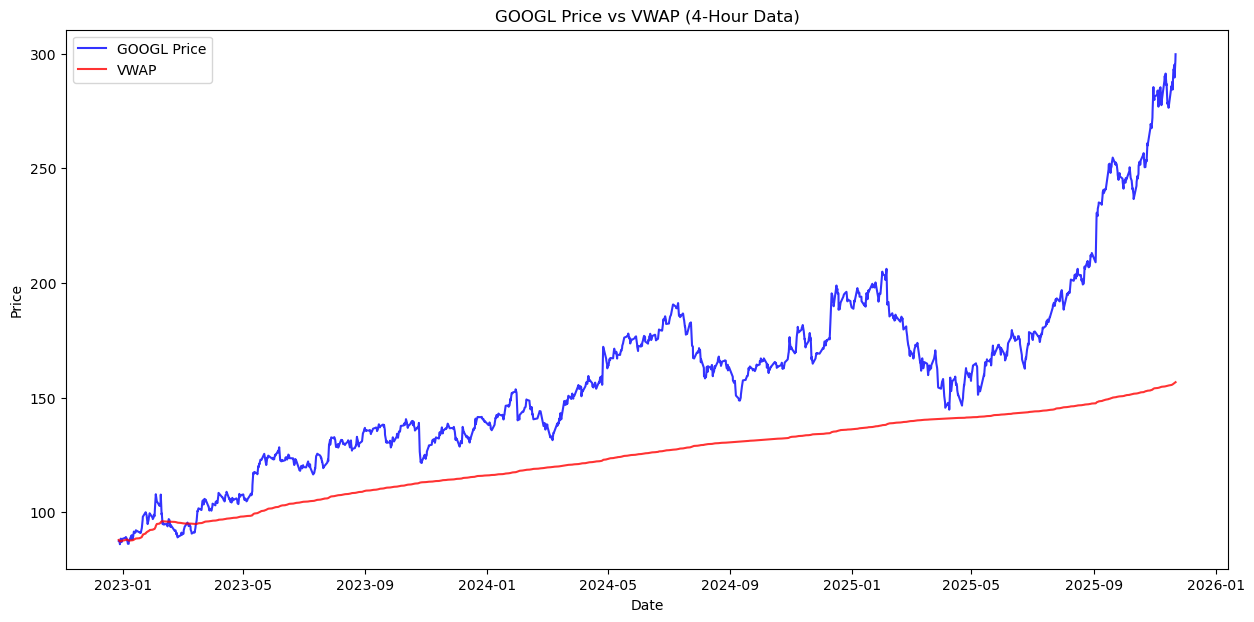

In [138]:
# plot close prices from df4h with vwap overlay
# calculate vwap
df4h['vwap'] = calculate_vwap(df4h)

plt.figure(figsize=(15,7))
plt.plot(df4h.index, df4h['Close'], label=f'{ticker_name} Price', color='blue', alpha=0.8)
plt.plot(df4h.index, df4h['vwap'], label='VWAP', color='red', alpha=0.8)
plt.title(f'{ticker_name} Price vs VWAP (4-Hour Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Save results to txt for 1H and 4H TF

In [139]:
# def save_results_to_txt(df: pd.DataFrame, file_name: str, data_path: str = "../02_VWAP/00_bt_results"):
#     """
#     Save DataFrame results to a text file in the specified directory
#     """
#     try:
#         # Create the directory if it doesn't exist
#         Path(data_path).mkdir(parents=True, exist_ok=True)
        
#         # Create full file path
#         full_file_path = os.path.join(data_path, file_name)
        
#         # Save the DataFrame to text file
#         with open(full_file_path, 'w') as f:
#             f.write(f"Results saved on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
#             f.write("=" * 80 + "\n\n")
#             f.write(df.to_string(index=False))
#             f.write(f"\n\n" + "=" * 80 + "\n")
#             f.write(f"Total records: {len(df)}\n")
        
#         print(f"Results saved to: {full_file_path}")
        
#     except Exception as e:
#         print(f"Error saving results to {full_file_path}: {e}")
        
#         # Try to save in current directory as fallback
#         try:
#             fallback_path = file_name
#             with open(fallback_path, 'w') as f:
#                 f.write(f"Results saved on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
#                 f.write("=" * 80 + "\n\n")
#                 f.write(df.to_string(index=False))
#                 f.write(f"\n\n" + "=" * 80 + "\n")
#                 f.write(f"Total records: {len(df)}\n")
#             print(f"Fallback: Results saved to current directory: {fallback_path}")
#         except Exception as e2:
#             print(f"Failed to save even in current directory: {e2}")

# def select_available_columns(df: pd.DataFrame, desired_columns: list) -> list:
#     """
#     Select columns that actually exist in the DataFrame from a list of desired columns
#     """
#     if df.empty:
#         return []
    
#     # # Define column mapping with alternatives
#     # column_alternatives = {
#     #     'Max Drawdown [%]': ['Max Drawdown [%]', 'Max. Drawdown [%]', 'MaxDrawdown [%]', 'Max Drawdown'],
#     #     'Win Rate [%]': ['Win Rate [%]', 'Win Rate', 'WinRate [%]'],
#     #     'Sharpe Ratio': ['Sharpe Ratio', 'SharpeRatio'],
#     #     'Return [%]': ['Return [%]'],
#     #     '# Trades': ['# Trades'],
#     #     'strategy_name': ['strategy_name'],
#     #     'Volatility (ann.) [%]': ['Volatility (ann.) [%]', 'Volatility [%]', 'Volatility']
#     # }
#     # Define column mapping with alternatives
#     # This dict, can be better structured.. to check more alternatives
#     column_alternatives = {
#         'Max Drawdown [%]': ['Max. Drawdown [%]'],
#         'Win Rate [%]': ['Win Rate [%]'],
#         'Sharpe Ratio': ['Sharpe Ratio'],
#         'Return [%]': ['Return [%]'],
#         '# Trades': ['# Trades'],
#         'strategy_name': ['strategy_name'],
#         'Volatility (ann.) [%]': ['Volatility (ann.) [%]']
#     }
    
#     available_columns = df.columns.tolist()
#     selected_columns = []
    
#     for desired_col in desired_columns:
#         # If the exact column exists, use it
#         if desired_col in available_columns:
#             selected_columns.append(desired_col)
#         # Otherwise, check alternatives
#         elif desired_col in column_alternatives:
#             alternatives = column_alternatives[desired_col]
#             for alt in alternatives:
#                 if alt in available_columns:
#                     selected_columns.append(alt)
#                     break
    
#     return selected_columns

# # Define the results directory path
# results_dir = "../02_VWAP/00_bt_results"

# # Save results to text files with proper column handling
# if 'oos_results' in locals() and len(oos_results) > 0:
#     print("Processing out-of-sample results for saving...")
    
#     # Save OOS comparison if available
#     if 'oos_comparison' in locals() and len(oos_comparison) > 0:
#         save_results_to_txt(
#             oos_comparison, 
#             f"{ticker_name}_oos_comparison.txt",
#             results_dir
#         )
    
#     # Save robust strategies if available
#     if 'robust_strategies' in locals() and len(robust_strategies) > 0:
#         save_results_to_txt(
#             robust_strategies, 
#             f"{ticker_name}_robust_strategies.txt",
#             results_dir
#         )
#     else:
#         print("No robust strategies found to save")
    
#     # Save full OOS results with available columns only
#     print("Available columns in oos_results:", oos_results.columns.tolist())
    
#     desired_oos_columns = ['strategy_name', 'Return [%]', '# Trades', 'Win Rate [%]', 
#                           'Sharpe Ratio', 'Max Drawdown [%]']
    
#     available_oos_columns = select_available_columns(oos_results, desired_oos_columns)
    
#     if available_oos_columns:
#         print(f"Saving OOS results with columns: {available_oos_columns}")
#         save_results_to_txt(
#             oos_results[available_oos_columns].copy(),
#             f"{ticker_name}_full_oos_results.txt",
#             results_dir
#         )
#     else:
#         print("No matching columns found for OOS results, saving all available columns")
#         save_results_to_txt(
#             oos_results,
#             f"{ticker_name}_full_oos_results.txt",
#             results_dir
#         )
        
# else:
#     print("No out-of-sample results available to save")

# # Save training results with available columns only
# if 'train_results' in locals() and len(train_results) > 0:
#     print("Processing training results for saving...")
#     print("Available columns in train_results:", train_results.columns.tolist())
    
#     # Define desired columns for training results
#     desired_train_columns = ['strategy_name', 'Return [%]', '# Trades', 'Win Rate [%]', 
#                             'Sharpe Ratio', 'Max Drawdown [%]']
    
#     available_train_columns = select_available_columns(train_results, desired_train_columns)
    
#     if available_train_columns:
#         print(f"Saving training results with columns: {available_train_columns}")
#         training_summary = train_results[available_train_columns].copy()
#     else:
#         print("No matching columns found for training results, using basic columns")
#         # Fallback to basic columns that should always exist
#         basic_columns = ['strategy_name', 'Return [%]', '# Trades']
#         basic_available = [col for col in basic_columns if col in train_results.columns]
#         if basic_available:
#             training_summary = train_results[basic_available].copy()
#         else:
#             # Last resort - save all columns
#             training_summary = train_results.copy()
    
#     save_results_to_txt(
#         training_summary,
#         f"{ticker_name}_training_results.txt", 
#         results_dir
#     )
# else:
#     print("No training results available to save")

# # print(f"\nResults directory: {os.path.abspath(results_dir)}")

# # Display summary of what was saved
# saved_files = []
# for file_type in ['oos_comparison', 'robust_strategies', 'full_oos_results', 'training_results']:
#     file_path = os.path.join(results_dir, f"{ticker_name}_{file_type}.txt")
#     if os.path.exists(file_path):
#         saved_files.append(f"{ticker_name}_{file_type}.txt")

# if saved_files:
#     print(f"\nSuccessfully saved {len(saved_files)} files:")
#     for file_name in saved_files:
#         print(f"  ✓ {file_name}")
# else:
#     print("\nNo files were saved successfully")